In [2]:
%matplotlib inline
import sys, os, glob, timeit

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.wcs import WCS

from multiprocess import Pool


from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

In [4]:
import pyqsofit
from pyqsofit.PyQSOFit import QSOFit
print(pyqsofit.__version__)

2.0.9


In [5]:
from scipy.stats import median_abs_deviation

In [125]:
flux_cal = False

## Setup PyQSOFit

In [126]:
path_ex = os.path.join('.')

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Hengxiao Guo'
primary_hdu = fits.PrimaryHDU(header=hdr0)

### Conditions and Parameters

In [127]:
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

newdata = np.rec.array([
    (6564.61, 'Ha', 6400, 6800, 'Ha_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (6564.61, 'Ha', 6400, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169/2, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 6400, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 5e-3, 1, 1, 1, 0.001, 1),
    (6585.28, 'Ha', 6400, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 5e-3, 1, 1, 1, 0.003, 1),
    (6718.29, 'Ha', 6400, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 5e-3, 1, 1, 2, 0.001, 1),
    (6732.67, 'Ha', 6400, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 5e-3, 1, 1, 2, 0.001, 1),

    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Hb', 4640, 5100, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 0.01, 1, 1, 0, 0.002, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 0.01, 1, 1, 0, 0.004, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.005, 1, 1, 0, 0.001, 1),

    (4341.68, 'Hg', 4310, 4370, 'Hg_na',   1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2,  0.01,  0, 1, 0, 0.002, 1),
    (4341.68, 'Hg', 4310, 4370, 'Hg_br',   1, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.01, 0, 0, 0, 0.01, 1),

    (3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169/2, 0.01, 99, 0, 0, -0.001, 1),

    (3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169/2, 0.01, 1, 1, 0, 0.001, 1),

    (3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169/2, 0.01, 0, 0, 0, 0.001, 1),
    (3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

    (2798.75, 'MgII', 2700, 2900, 'MgII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (2798.75, 'MgII', 2700, 2900, 'MgII_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169/2, 0.01, 1, 1, 0, 0.002, 1),

    (1908.73, 'CIII', 1700, 1970, 'CIII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01, 1),
    #(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.0, 0.0, 1e10, 1e-3, 5e-4,  0.00169, 0.01,  1, 1, 0, 0.002, 1),
    #(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
    #(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

    (1549.06, 'CIV', 1500, 1700, 'CIV_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    # (1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

    (1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    (1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
    #(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

    (1215.67, 'Lya', 1150, 1290, 'Lya_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05, 0.02, 0, 0, 0, 0.05, 1),
    (1240.14, 'Lya', 1150, 1290, 'NV1240', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.01, 0.005, 0, 0, 0, 0.002, 1),
    (1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 0, 0, 0, 0.002, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=newdata, header=hdr1, name='line_priors')

In [128]:
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (900., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1540.), # modified
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2700.), # modified 2
    (2925., 3400.),
    (3500., 3610.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4755.), # modified
    (5100., 6400.),  # modified 3 The He line is not strong
    #(6005., 6035.), # modified 3
    #(6110., 6250.), # modified 3
    (6750., 7000.), # modified
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  1), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 1), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  1), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 1), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     1.0,   0.0,   1e8,  1), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   1), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  1), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 1), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.5,   0.1,   2.0,   1), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',  0, -1e10, 1e2,  1), # 1st coefficient of the polynomial continuum
    ('conti_a_1',  0, -1e10, 1e2,  1), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',  0, -1e10, 1e2,  1), # 3rd coefficient of the polynomial continuum
    # TODO: In a future version, we may add options to add more if you want...
    # ('conti_pl_3',  0.0,  -1e10,  1e10,  1), # 4th coefficient of the polynomial continuum
    # ('conti_pl_4',  0.0,  -1e10,  1e10,  1), # 5th coefficient of the polynomial continuum
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

In [129]:
"""
In this table, we allow user to customized some key parameters in our result measurements.
"""
cont_loc = [1350, 1450, 2200, 3000, 4200, 5100]
BC =       [9.26, 9.26, 9.26, 5.15, 5.15, 3.81]
measure_info = Table(
    [
        [[1350, 1450, 2200, 3000, 4200, 5100]],
        [[
            # [2240, 2650], 
            [4435, 4685],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto('/Users/diegomiura/dwarf_agn_cosmos/qsopar.fits', overwrite=True)

In [130]:
fits.open('/Users/diegomiura/dwarf_agn_cosmos/qsopar.fits')

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x16c2c2150>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x16a9f65d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x15a52c850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x15a54cb90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x15a54f890>]

## Fit the spectra

In [131]:
data_agn_updated = ascii.read('des_agn_updated.txt')

ra, dec = data_agn_updated['RA'], data_agn_updated['dec']
data_coords = SkyCoord(ra, dec, unit=[u.deg, u.deg])

data_agn_updated['err_reason'] = False

Pipeline to loop through each source, get the spectrum (if there is one), and fit it.

### MBH Calculation Function

In [132]:
def calc_M_BH_vir(logL, FWHM_line, FWHM_res=69, line_name='Ha', method='conti'):
    """
    Calculate the single-epoch (virial) black hole mass from the
    continuum luminosity and broad line FWHM
    
    Parameter:
    ----------
    logL: float
        log10 of the continuum or broad-line line luminosity in erg / s
        
    FWHM: float
        broad line FWHM in km / s

    line_name: str

    method: str
    
    Return:
    -----------
    Computed black hole mass M_BH,vir in Solar masses    
    
    "This approach assumes that the broad-line region (BLR)
    is virialized, the continuum luminosity is used as a proxy
    for the BLR radius, and the broad line width (FWHM) is used
    as a proxy for the virial velocity." -- Shen et al. (2011)
    """
    
    key = line_name.split('_')[0] # Remove the _br

    if method == 'conti':
        
        #    VP06           S11            VP06
        a = {'Hb': 0.910 , 'MgII': 0.740, 'CIV':0.660}
        b = {'Hb': 0.50,   'MgII': 0.62,  'CIV':0.53}

    elif method == 'line':

        a = {'Hb': 1.63 , 'MgII': 1.70, 'CIV':1.52}
        b = {'Hb': 0.49,  'MgII': 0.63, 'CIV':0.46}
    
    # Subtract component from instrumental broadening
    FWHM = np.sqrt(FWHM_line**2 - FWHM_res**2)
    
    return a[key] + b[key]*(logL-44) + 2*np.log10(FWHM)

### Flux Calibration Function

In [133]:
import pickle

def flux_calib(ID, wave, flux, flux_err, src):

    if flux_cal == False:
        return flux, flux_err, 0

    else:

        # Convert spectrum to photometry
        # bands: 
        filter_dir = '/Users/diegomiura/dwarf_agn_cosmos/des/cigale-v2022.1/pcigale/data/filters'
    
        #TODO: Add y, JHK
        #bands = ['ctio.decam.u', 'ctio.decam.g', 'ctio.decam.r', 'ctio.decam.i', 'ctio.decam.z', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks']
        bands = ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks']


        # Get the COSMOS2020 photometry

        dat_phot = Table.read('/Users/diegomiura/dwarf_agn_cosmos/cigale/des/data_phot.dat', format='ascii')
        dat_phot['u_prime'] = dat_phot['ctio.decam.u']
        dat_phot['g_prime'] = dat_phot['ctio.decam.g']
        dat_phot['r_prime'] = dat_phot['ctio.decam.r']
        dat_phot['i_prime'] = dat_phot['ctio.decam.i']
        dat_phot['z_prime'] = dat_phot['ctio.decam.z']
        dat_phot['u_prime_err'] = dat_phot['ctio.decam.u_err']
        dat_phot['g_prime_err'] = dat_phot['ctio.decam.g_err']
        dat_phot['r_prime_err'] = dat_phot['ctio.decam.r_err']
        dat_phot['i_prime_err'] = dat_phot['ctio.decam.i_err']
        dat_phot['z_prime_err'] = dat_phot['ctio.decam.z_err']
        #### ...
            
        rs = np.full(len(bands), np.nan)
        fluxes_e = np.full(len(bands), np.nan)
    
        # Convert cigale filter to pyphot filter and get the spectrophotometric flux
        for i, band in enumerate(bands):
    
            with open(os.path.join(filter_dir, f'name={band}.pickle'), 'rb') as pickle_file:
                filter_ = pickle.load(pickle_file)
                wl = filter_.wl
                tr = filter_.tr
                lambda_piv = filter_.pivot
            # Convert flux 
            mask_f = np.isfinite(flux) & (flux > 0)
            print(len(flux[mask_f]))
            #f_l = (flux[mask_f]*1e-17*u.erg/u.s/u.cm**2/u.AA).to(u.W/u.m**2/u.nm, equivalencies=u.spectral_density(wave[mask_f]*u.AA)).value
            # Interpolate to a grid
            print('I got here')
            if (len(flux[mask_f]) > 0):
                print('I got here 2')
                if (np.min(wave[mask_f]/10) < lambda_piv-20) & (np.max(wave[mask_f]/10) > lambda_piv+20):
                    print('I got here 3')
                    f_l = (flux[mask_f]*1e-17*u.erg/u.s/u.cm**2/u.AA).to(u.W/u.m**2/u.nm, equivalencies=u.spectral_density(wave[mask_f]*u.AA)).value
                    wl_grid = np.arange(np.min(wave[mask_f]/10), np.max(wave[mask_f]/10), 1)
                    tr_grid = np.interp(wl_grid, wl, tr)
                    f_l_grid = np.interp(wl_grid, wave[mask_f]/10, f_l)
                    # # Fλ flux density in W/m²/nm
                    # We compute directly Fν from ∫T×Fλ×dλ
                    # Normalisation is such that the results we obtain are directly in mJy
                    # https://gitlab.lam.fr/cigale/cigale/-/blob/master/pcigale/sed/__init__.py?ref_type=heads
                    flux_spectro = np.trapz(tr_grid * f_l_grid, x=wl_grid)
                    print('flux_spectro', flux_spectro)
                    #plt.errorbar(np.mean(wl), flux_spectro, marker='o', markersize=20, color='gray')
                    ft = (flux[mask_f]*1e-17*u.erg/u.s/u.cm**2/u.AA).to(u.mJy, equivalencies=u.spectral_density(wave[mask_f]*u.AA)).value
                    #plt.plot(wl_grid, np.interp(wl_grid, wave[mask_f]/10, ft), color='k')
                    # Get photometry
                    if ID in dat_phot['id']:
                        print('I got here 4')
                        print('have photometry')
                        flux_band = dat_phot[band][dat_phot['id']==ID][0]
                        fe = dat_phot[band+'_err'][dat_phot['id']==ID][0]
                        if fe > 0:
                            plt.errorbar(np.mean(wl), flux_band, yerr=fe, marker='o', markersize=20, color='orange')
                        print(band)
                        print('flux-band:',flux_band)
                        print('flux_e-band:',fe)
                        print('flux-spectro-band:',flux_spectro)
                        if (len(dat_phot[band][dat_phot['id']==ID]) > 0) & (fe > 0):
                            fluxes_e[i] = fe
                        if (flux_band > 0) & (flux_spectro > 0):
                            rs[i] = flux_band/flux_spectro
                    else:
                        print('NO COSMOS2020 optical PHOTOMETRY')
                        data_agn_updated['err_reason'][ID-1] = 'NO COSMOS2020 optical PHOTOMETRY'
                        return flux, flux_err, 0
    
        # TODO: flag unable to flux calibrate error weighted
        mask = (rs > 0) & np.isfinite(rs) & np.isfinite(fluxes_e)
        if len(rs[mask]) == 0:
            print(f'WARNING: unable to flux calibrate {ID}')
            data_agn_updated['err_reason'][ID-1] = 'Flux Calibration'
            return flux, flux_err, 0
        r = np.average(rs[mask], weights=1/fluxes_e[mask])
        print('flux-weighted mean:',r)
        print('rs:',rs[mask])
        
        plt.plot(wl_grid, np.interp(wl_grid, wave[mask_f]/10, ft)*r, color='r')
        plt.title(f'ID: {ID} Survey: {src}')
        plt.show()

        # TODO: Flag unable to flux calibrate
        return flux*r, flux_err*r, 1

In [134]:
dat_phot = Table.read('/Users/diegomiura/dwarf_agn_cosmos/cigale/des/data_phot.dat', format='ascii')

dat_phot

id,redshift,chandra.0p5to7,chandra.0p5to7_err,chandra.2to7,chandra.2to7_err,chandra.1p2to2,chandra.1p2to2_err,chandra.0p5to1p2,chandra.0p5to1p2_err,chandra.0p2to0p5,chandra.0p2to0p5_err,xmm.newton.0p2to0p5,xmm.newton.0p2to0p5_err,xmm.newton.0p5to1,xmm.newton.0p5to1_err,xmm.newton.1to2,xmm.newton.1to2_err,xmm.newton.2to4p5,xmm.newton.2to4p5_err,xmm.newton.4p5to12,xmm.newton.4p5to12_err,xmm.newton.0p2to12,xmm.newton.0p2to12_err,xmm.newton.0p5to4p5,xmm.newton.0p5to4p5_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,ctio.decam.u,ctio.decam.u_err,ctio.decam.g,ctio.decam.g_err,ctio.decam.r,ctio.decam.r_err,ctio.decam.i,ctio.decam.i_err,ctio.decam.z,ctio.decam.z_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,WISE1,WISE1_err,WISE2,WISE2_err,WISE3,WISE3_err,WISE4,WISE4_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1.02,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0008032896460231528,7.590688135295232e-05,0.0013163325280635104,1.6472165090050196e-05,0.002173463244116507,2.1944114686963572e-05,0.0031526614544590513,3.579858072233029e-05,0.005009728864800938,6.512359844665794e-05,0.005997794395643373,0.00018558643726299757,0.009719915705767515,0.0002627762867158613,0.01931272405273045,0.00029943104889366897,0.049519,0.000614,0.048307,0.0009220000000000001,0.053968,0.003203,0.024233,0.005898,-9999.0,-9999.0,0.040888,0.0032010000000000003,0.029813,0.0064800000000000005,0.149968,0.0,1.102554,0.0
2,0.24,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,6.783156729786637e-07,2.431620964642342e-07,6.86453012739131e-07,1.8775848630680383e-07,9.33250636820141e-07,1.7273939549865512e-07,4.9230822837473726e-08,7.774112337981954e-08,1.7628035418076133e-07,2.1660090853633057e-07,3.073270742434247e-07,1.440719423876687e-07,5.403642734462229e-07,8.019369839412632e-08,-9999.0,-9999.0,-9999.0,-9999.0,0.0013732546526433959,4.94215392059272e-05,0.0016412360461274878,1.6442413685831735e-05,0.0015989142653076432,2.30331724280241e-05,0.0024368051456875703,3.736079507220424e-05,0.0021077423001598736,7.076393199492252e-05,0.00467573614183411,4.3767823155762346e-05,0.006327461415900535,6.192133286787478e-05,0.007927952010727735,8.045975594802534e-05,0.01235,0.000507,0.015982,0.0007650000000000001,0.034688000000000004,0.00311,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,1.09,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1.7528889677821878e-06,3.258299580580452e-07,1.4434059255741837e-06,2.389836935344421e-07,1.2181857341351043e-06,1.758208814996331e-07,5.193571493796981e-07,1.3371060316266102e-07,2.509561758058569e-07,2.4216540054927555e-07,5.90061645863311e-07,1.5897471578943982e-07,9.190828732074041e-07,8.810688496542044e-08,-9999.0,-9999.0,-9999.0,-9999.0,0.003063723994519411,5.1942131014890944e-05,0.0021509110833861263,1.721200417144812e-05,0.002755000441801383,2.342050680132274e-05,0.002650053747901249,3.5764438013923185e-05,0.0032885023028217737,6.227375519409695e-05,0.004411067325517923,0.00013400839767430868,0.0065456732257520465,0.0002255751695764651,0.

In [135]:
import pyqsofit
pyqsofit.__version__

'2.0.9'

### Use fit & MBH equation function to calculate MBH for each AGN

In [136]:
bad_ID =[]

def measureMBH(ID, src, z, wave, flux, flux_err):
    
    fill = np.full(len(data_agn_BH.colnames)-1, -1.0)
    # Add a row to the table
    data_agn_BH.add_row(np.concatenate(([ID], fill)))
    
    name = 'rev_ID = '+str(ID) + ',' + str(src)

    #plt.plot(wave, flux)
    #plt.plot(wave, flux_err)

    #if (ID == 26) or (ID == 490) or (ID == 482) or (ID == 404):
    if False:
        # Special 
        # Visual inspection reveals host only.
        q = QSOFit(wave, flux, flux_err, z, path=path_ex)
        q.Fit(name=name, nsmooth=1, deredden=True, reject_badpix=True,  #wave_range= np.array([1000, 11000]), \
              wave_mask=None, decompose_host=True, BC=False, npca_gal=15, npca_qso=1, \
              Fe_uv_op=False, poly=True, rej_abs_conti=True, rej_abs_line=True, MC=True, nsamp=20, linefit=True, \
              plot_fig=False, save_result=False, kwargs_plot={'save_fig_path': '.', 'plot_br_prop':True},
              save_fits_name=None, verbose=False, save_fig=True, param_file_name='/Users/colinburke/research/dwarf_agn_cosmos/qsopar.fits')
    else:
    
    #TODO: Testing 'FAILED to FIT'

        # Prepare data
        try:
            q_noFeII = QSOFit(wave, flux, flux_err, z, path=path_ex)
            q_noFeII.Fit(name=name, nsmooth=1, deredden=True, reject_badpix=True,  #wave_range= np.array([1000, 11000]), \
                wave_mask=None, decompose_host=True, BC03=True, BC=False, npca_gal=5, npca_qso=5, \
                Fe_uv_op=False, poly=True, rej_abs_conti=False, rej_abs_line=True, MC=True, nsamp=20, linefit=True, \
                plot_fig=False, save_result=False, kwargs_plot={'save_fig_path': '.', 'plot_br_prop':True},
                save_fits_name=None, verbose=False, save_fig=True, param_file_name='/Users/diegomiura/dwarf_agn_cosmos/qsopar.fits')
        except:
            plt.plot(wave, flux)
            plt.plot(wave, flux_err)
            data_agn_updated['err_reason'][ID-1] = 'Failed to fit'
            print(f'FAILED TO FIT ID: {ID}')
            bad_ID.append(ID)
            return
        
        ## IF the chi2 is really bad > 10, remove Fe II and try again
        q_FeII = QSOFit(wave, flux, flux_err, z, path=path_ex)
        q_FeII.Fit(name=name, nsmooth=1, deredden=True, reject_badpix=True,  #wave_range= np.array([1000, 11000]), \
                wave_mask=None, decompose_host=True, BC03=True, BC=False, npca_gal=5, npca_qso=5, \
                Fe_uv_op=True, poly=True, rej_abs_conti=True, rej_abs_line=True, MC=True, nsamp=20, linefit=True, \
                plot_fig=False, save_result=False, kwargs_plot={'save_fig_path': '.', 'plot_br_prop':True},
                save_fits_name=None, verbose=False, save_fig=True, param_file_name='/Users/diegomiura/dwarf_agn_cosmos/qsopar.fits')

        # Use Fe II it if chi2 improves by ~20%
        if (q_noFeII.conti_fit.redchi - q_FeII.conti_fit.redchi)/q_FeII.conti_fit.redchi > 0.2:
            q = q_FeII
            print('use Fe ii')
        else:
            q = q_noFeII

    # TODO: consider error 
    Lconti = -1
    Lbol = -1

    data_agn_BH['SNR'][-1] = q.SN_ratio_conti
    data_agn_BH['src'][-1] = src

    data_agn_BH['f_conti'][-1] = np.median(q.PL_poly_BC/q.host)
    
    try:
        if ID==290: ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            fig, ax = plt.subplots(figsize=(15, 5))

            # Plot the quasar rest frame spectrum after removed the host galaxy component
            ax.plot(q.wave, q.Smooth(q.flux, 8), 'k', label='Data', lw=1)
            
            # Skip the error results before plotting
            if q.MCMC == True:
                gauss_result = q.gauss_result[::2]
            else:
                gauss_result = q.gauss_result

            # Plot individual line components
            br_tot = np.zeros_like(q.wave)
            na_tot = np.zeros_like(q.wave)
            for p in range(int(len(gauss_result) / 3)):
                if q.CalFWHM(gauss_result[3 * p + 2]) > 1200:  # < 1200 km/s narrow
                    br_tot += q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3])
                else:
                    na_tot += q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3])
            ax.plot(q.wave, br_tot + q.f_conti_model, color='r', label='Broad Model', zorder=100)
            ax.plot(q.wave, na_tot + q.f_conti_model, color='g', label='Narrow Model', zorder=99)
            
            # To plot the whole model, we use Manygauss to show the line fitting results saved in gauss_result
            ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result) + q.f_conti_model, 'b', label='Total Model', lw=3.5, zorder=98)
            ax.plot(q.wave, q.PL_poly_BC, 'orange', lw=2, label='Continuum')
            ax.plot(q.wave, q.qso, 'pink', lw=2, label='Host+QSO Template')
            ax.plot(q.wave, q.host, 'm', lw=2, label='Host')
            plt.legend(fontsize=12, loc=4, frameon=True)
            
            ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
            ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

            line_cen = np.array(
                [6564.60, 6549.85, 6585.27, 6718.29, 6732.66, 4862.68, 5008.24, 4687.02, 4341.68, 3934.78, 3728.47,
                 3426.84, 2798.75, 1908.72, 1816.97, 1750.26, 1718.55, 1549.06, 1640.42, 1402.06, 1396.76, 1335.30, \
                 1215.67])
            
            line_name = np.array(
                ['', '', r'H$\alpha$+[NII]', '', '[SII]6718,6732', r'H$\beta$', '[OIII]', 'HeII4687', r'H$\gamma$', 'CaII3934', '[OII]3728',
                 'NeV3426', 'MgII', 'CIII]', 'SiII1816', 'NIII]1750', 'NIV]1718', 'CIV', 'HeII1640', '', 'SiIV+OIV',
                 'CII1335', r'Ly$\alpha$'])
            
            ax.set_ylim(-1.8, 8.4)
            
            # Line position
            axis_to_data = ax.transAxes + ax.transData.inverted()
            points_data = axis_to_data.transform((0, 0.92))

            for ll in range(len(line_cen)):
                if q.wave.min() < line_cen[ll] < q.wave.max():
                    ax.axvline(line_cen[ll], color='k', linestyle=':')
                    # ax.plot([line_cen[ll], line_cen[ll]], ylims, 'k:')
                    ax.text(line_cen[ll] + 7, points_data[1], line_name[ll], rotation=90, fontsize=10, va='top')

            ax.set_xlim(np.min(q.wave), np.max(q.wave))
            fig.tight_layout()
            fig.savefig(f'spec{src}.pdf', dpi=300)
            
        ###
        q.plot_fig(plot_br_prop=True, save_fig_path='/Users/diegomiura/dwarf_agn_cosmos/des/fits')
        plt.show()
    except:
        ## DEBUG
        data_agn_updated['err_reason'][ID-1] = 'Bad Spec'
        print('bad spec!')

    for k, c in enumerate(cont_loc):
        Lconti = float(q.conti_result[q.conti_result_name==f'L{c}'][0])
        if Lconti > 0:
            data_agn_BH['Lconti'][-1] = Lconti
        print(c, q.conti_result[q.conti_result_name==f'L{c}'])
        Lbol = np.log10(BC[k]*10**Lconti)
        if Lbol > 0:
            data_agn_BH['Lbol'][-1] = Lbol

    snr_Hbs = []
    snr_MgIIs = []
    snr_CIVs = []

    M_BH_Hbs = []
    M_BH_MgIIs = []
    M_BH_CIVs = []

    M_BH_Hbs_line = []
    M_BH_MgIIs_line = []
    M_BH_CIVs_line = []

    Lconti = data_agn_BH['Lconti'][-1]
    print('Lconti', Lconti)
    
    for j in range(20):
        line_name = 'Hb_br'
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(line_name, line_type='broad', sample_index=j)
        print('Hb', fwhm)
        print('snr', snr)
        snr_Hbs.append(snr)
        M_BH_Hbs.append(calc_M_BH_vir(Lconti, fwhm, line_name=line_name))
        M_BH_Hbs_line.append(calc_M_BH_vir(np.log10(q.flux2L(area)), fwhm, line_name=line_name, method='line'))
    if np.nanmean(snr_Hbs) < 2:
        M_BH_Hbs = []
        M_BH_Hbs_line = []

    for j in range(20):
        line_name = 'MgII_br'
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(line_name, line_type='broad', sample_index=j)
        print('MgII', fwhm)
        print('snr', snr)
        snr_MgIIs.append(snr)
        M_BH_MgIIs.append(calc_M_BH_vir(Lconti, fwhm, line_name=line_name))
        M_BH_MgIIs_line.append(calc_M_BH_vir(np.log10(q.flux2L(area)), fwhm, line_name=line_name, method='line'))
    if (np.nanmean(snr_MgIIs) < 2) or (ID==3): # THREE IS BAD
        M_BH_MgIIs = []
        M_BH_MgIIs_line = []

    for j in range(20):
        line_name = 'CIV_br'
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(line_name, line_type='broad', sample_index=j)
        print('CIV', fwhm)
        print('snr', snr)
        snr_CIVs.append(snr)
        M_BH_CIVs.append(calc_M_BH_vir(Lconti, fwhm, line_name=line_name))
        M_BH_CIVs_line.append(calc_M_BH_vir(np.log10(q.flux2L(area)), fwhm, line_name=line_name, method='line'))
    if np.nanmean(snr_CIVs) < 2:
        M_BH_CIVs = []
        M_BH_CIVs_line = []
        

    # Line calculations
    data_agn_BH['M_Hb'][-1] = np.nanmedian(M_BH_Hbs)
    data_agn_BH['M_MgII'][-1] = np.nanmedian(M_BH_MgIIs)
    data_agn_BH['M_CIV'][-1] = np.nanmedian(M_BH_CIVs)

    print(M_BH_Hbs_line)
    print(M_BH_MgIIs_line)
    print(M_BH_CIVs_line)

    data_agn_BH['M_Hb_line'][-1] = np.nanmedian(M_BH_Hbs_line)
    data_agn_BH['M_MgII_line'][-1] = np.nanmedian(M_BH_MgIIs_line)
    data_agn_BH['M_CIV_line'][-1] = np.nanmedian(M_BH_CIVs_line)

    data_agn_BH['M_Hb_e'][-1] = np.std(M_BH_Hbs)
    data_agn_BH['M_MgII_e'][-1] = np.std(M_BH_MgIIs)
    data_agn_BH['M_CIV_e'][-1] = np.std(M_BH_CIVs)

    data_agn_BH['M_Hb_line_e'][-1] = np.std(M_BH_Hbs_line)
    data_agn_BH['M_MgII_line_e'][-1] = np.std(M_BH_MgIIs_line)
    data_agn_BH['M_CIV_line_e'][-1] = np.std(M_BH_CIVs_line)

    # Pick fiducial BH mass for each spectrum:
    if np.isfinite(data_agn_BH['M_Hb'][-1]) & (data_agn_BH['M_Hb'][-1] > 0):
        data_agn_BH['M'][-1] = data_agn_BH['M_Hb'][-1]
    elif np.isfinite(data_agn_BH['M_MgII'][-1]) & (data_agn_BH['M_MgII'][-1] > 0):
        data_agn_BH['M'][-1] = data_agn_BH['M_MgII'][-1]
    elif np.isfinite(data_agn_BH['M_CIV'][-1]) & (data_agn_BH['M_CIV'][-1] > 0):
        data_agn_BH['M'][-1] = data_agn_BH['M_CIV'][-1]

    # Pick fiducial BH mass for each spectrum:
    if np.isfinite(data_agn_BH['M_Hb_line'][-1]) & (data_agn_BH['M_Hb_line'][-1] > 0):
        data_agn_BH['M_line'][-1] = data_agn_BH['M_Hb_line'][-1]
        data_agn_BH['M_line_e'][-1] = data_agn_BH['M_Hb_line_e'][-1]
    elif np.isfinite(data_agn_BH['M_MgII_line'][-1]) & (data_agn_BH['M_MgII_line'][-1] > 0):
        data_agn_BH['M_line'][-1] = data_agn_BH['M_MgII_line'][-1]
        data_agn_BH['M_line_e'][-1] = data_agn_BH['M_MgII_line_e'][-1]
    elif np.isfinite(data_agn_BH['M_CIV_line'][-1]) & (data_agn_BH['M_CIV_line'][-1] > 0):
        data_agn_BH['M_line'][-1] = data_agn_BH['M_CIV_line'][-1]
        data_agn_BH['M_line_e'][-1] = data_agn_BH['M_CIV_line_e'][-1]
    
    #### Save the figures here
    print('MASS')
    return


In [137]:
print(flux_cal)

False


### Conditions and Parameters

In [138]:
data_agn_BH = Table(np.array([-1]), names=['ID']) # dummy row

data_agn_BH['SNR'] = -1. # overall SNR of the spectrum
data_agn_BH['src'] = -1

data_agn_BH['flag_cal'] = 0

data_agn_BH['f_conti'] = -1.

for c in cont_loc:
    data_agn_BH[f'L{c}'] = -1.

data_agn_BH['Lconti'] = -1.
data_agn_BH['Lbol'] = -1.

# Fiducial BH mass
data_agn_BH['M'] = -1.
data_agn_BH['M_line'] = -1.
data_agn_BH['M_line_e'] = -1.

data_agn_BH['M_Hb'] = -1.
data_agn_BH['M_MgII'] = -1.
data_agn_BH['M_CIV'] = -1.

data_agn_BH['M_Hb_line'] = -1.
data_agn_BH['M_MgII_line'] = -1.
data_agn_BH['M_CIV_line'] = -1.

data_agn_BH['M_Hb_e'] = -1.
data_agn_BH['M_MgII_e'] = -1.
data_agn_BH['M_CIV_e'] = -1.

data_agn_BH['M_Hb_line_e'] = -1.
data_agn_BH['M_MgII_line_e'] = -1.
data_agn_BH['M_CIV_line_e'] = -1.

# ADD FWHM and Luminosity
# TODO: Plot line luminosity detected vs redshift for different surveys

line_cen = np.array( [6564.60,            4862.68,    2797,    1908, 1549.06, 1215.67])
line_name = np.array([r'H$\alpha$+[NII]', r'H$\beta$','MgII'  , 'CIII]', 'CIV',   r'Ly$\alpha$'])

wmin = 4000
wmax = 11000

### Loop through list of AGN, and calculate MBH

ID:: 1
ID:: 2
ID:: 3
ID:: 4
ID:: 5
ID:: 6
6 has a x5700 spectra, z = 0.8018800020217896
mask
[1 1 1 ... 0 0 0]
STEP
SAVE
Saving figure as /Users/diegomiura/dwarf_agn_cosmos/des/fits/rev_ID = 6,8.pdf
1350 ['-1.0']
1450 ['-1.0']
2200 ['44.490158047617726']
3000 ['44.33997402779688']
4200 ['43.63600288764052']
5100 ['-1.0']
Lconti 43.63600288764052
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
MgII 5495.88482556953
snr 8.248941786294921
20
20
MgII 5523.2734710431305
snr 8.260854917864608
20
20
MgII 5482.241054206099
snr 8.238377419533661
20
20
MgII 5379.6012218221185
snr 8.354759895559583
20
20
MgII 5477.810605778853
snr 8.229279597454223
20
20
MgII 5482.4329919235
snr 8.333083870377871
20
20
M

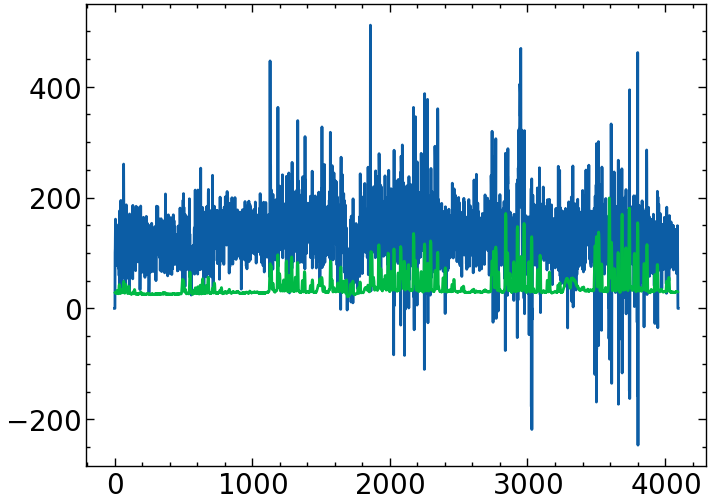

ivar [inf inf inf ... inf inf inf]
STEP
SAVE
Saving figure as /Users/diegomiura/dwarf_agn_cosmos/des/fits/rev_ID = 47,3.pdf
1350 ['-1.0']
1450 ['-1.0']
2200 ['-1.0']
3000 ['46.81346213483711']
4200 ['-1.0']
5100 ['-1.0']
Lconti 46.81346213483711
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
[]
[]
[]
MASS
ID:: 48
48 has a x57

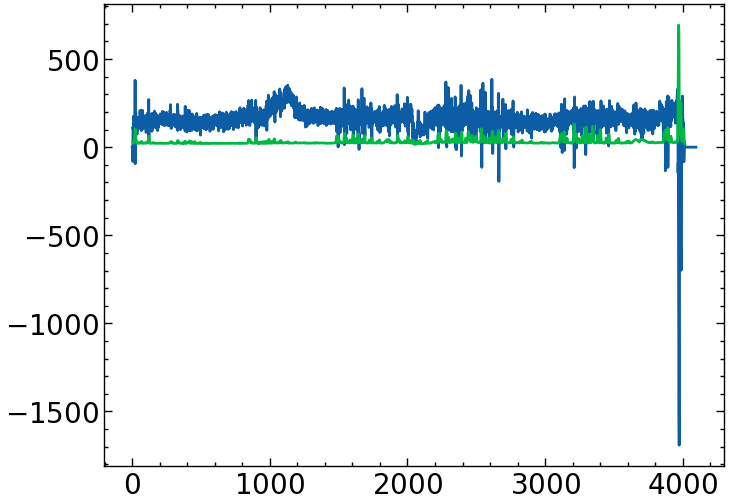

ivar [inf inf inf ... inf inf inf]
STEP
SAVE
Saving figure as /Users/diegomiura/dwarf_agn_cosmos/des/fits/rev_ID = 108,3.pdf
1350 ['-1.0']
1450 ['-1.0']
2200 ['47.78789340835963']
3000 ['-1.0']
4200 ['-1.0']
5100 ['-1.0']
Lconti 47.78789340835963
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
[]
[]
[]
MASS
ID:: 109
ID:: 110
1

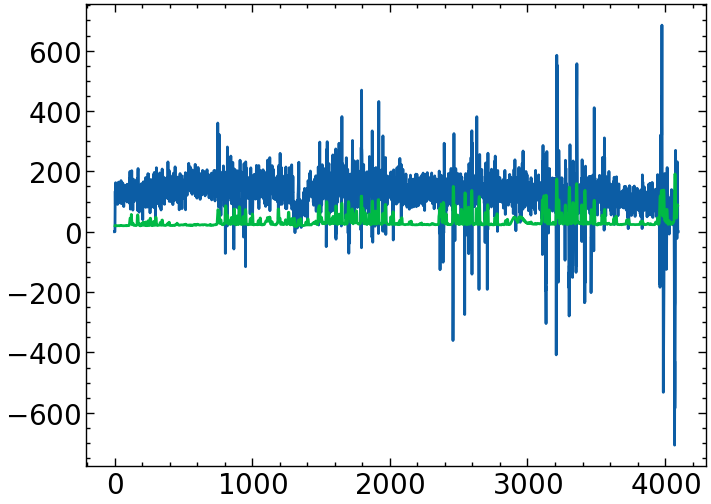

ivar [inf inf inf ... inf inf inf]
STEP
SAVE
Saving figure as /Users/diegomiura/dwarf_agn_cosmos/des/fits/rev_ID = 110,3.pdf
1350 ['-1.0']
1450 ['-1.0']
2200 ['47.711754133250125']
3000 ['-1.0']
4200 ['-1.0']
5100 ['-1.0']
Lconti 47.711754133250125
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
[]
[]
[]
MASS
ID:: 111
ID:: 112

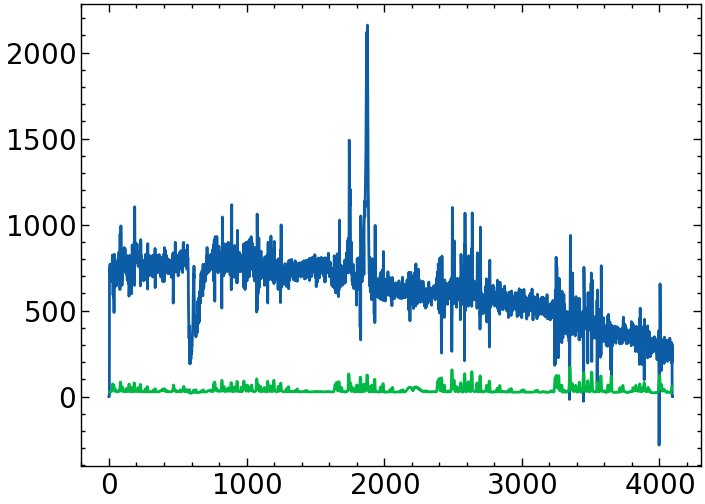

ivar [inf inf inf ... inf inf inf]
STEP
SAVE
Saving figure as /Users/diegomiura/dwarf_agn_cosmos/des/fits/rev_ID = 130,3.pdf
1350 ['-1.0']
1450 ['-1.0']
2200 ['-1.0']
3000 ['-1.0']
4200 ['-1.0']
5100 ['46.63616641106876']
Lconti 46.63616641106876
20
20
Hb 3889.596463555799
snr 1.1033933562868428
20
20
Hb 3495.3914642760146
snr 1.207623756956066
20
20
Hb 3567.310032536803
snr 1.0601518833821346
20
20
Hb 3522.948223531639
snr 1.2225392708448044
20
20
Hb 3626.392057339016
snr 1.1525659189264952
20
20
Hb 3500.2634519106505
snr 1.1000659817281941
20
20
Hb 3556.4343176732837
snr 1.2246270940273545
20
20
Hb 4127.706462422553
snr 1.0590294960558435
20
20
Hb 3409.321006518661
snr 1.263627559223698
20
20
Hb 3806.4974428904243
snr 1.0653371472712374
20
20
Hb 3666.3032129536796
snr 1.1971534037080507
20
20
Hb 3635.342714352236
snr 1.2266627305491677
20
20
Hb 3738.925249313126
snr 1.1342808127065462
20
20
Hb 3727.337073017029
snr 1.09633768820152
20
20
Hb 3680.7647227322195
snr 1.129418069249805
20

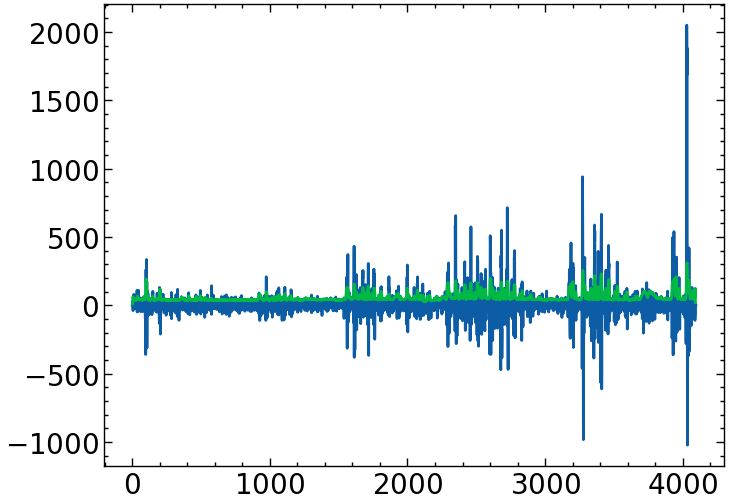

ivar [inf inf inf ... inf inf inf]
STEP
SAVE
Saving figure as /Users/diegomiura/dwarf_agn_cosmos/des/fits/rev_ID = 132,3.pdf
1350 ['-1.0']
1450 ['-1.0']
2200 ['44.43459876482564']
3000 ['-1.0']
4200 ['-1.0']
5100 ['-1.0']
Lconti 44.43459876482564
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
[]
[]
[]
MASS
ID:: 133
133 has a 

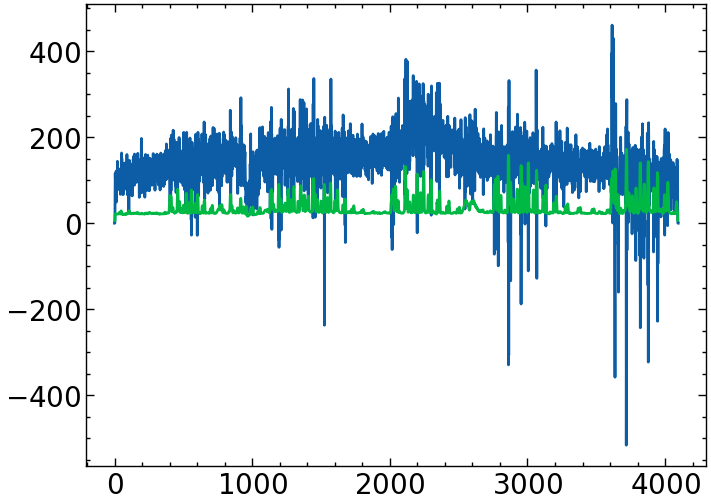

ivar [inf inf inf ... inf inf inf]
STEP
SAVE
Saving figure as /Users/diegomiura/dwarf_agn_cosmos/des/fits/rev_ID = 248,3.pdf
1350 ['-1.0']
1450 ['-1.0']
2200 ['-1.0']
3000 ['47.54440869499416']
4200 ['-1.0']
5100 ['-1.0']
Lconti 47.54440869499416
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
20
20
MgII 6685.036121739777
snr 2.268385422928195
20
20
MgII 4520.911739756229
snr 2.834505447173994
20
20
MgII 6026.260726168156
snr 2.2893127440161902
20
20
MgII 5628.858732248844
snr 2.7355297801597067
20
20
MgII 4689.230593195035
snr 2.8615548835495708
20
20
MgII 4872.28838381506
snr 2.5167516323788544
20
20
MgII 5701.726444744112
snr 2.743521167525738
20
20
MgII 5130.1492180444075
snr 2.6806063039973314
20
20
MgII 5622.274364218655
snr 2.5522915709793597
20
20
MgII 5221.023351044477
snr 2.6946461489319384
20
20
MgII 4717.

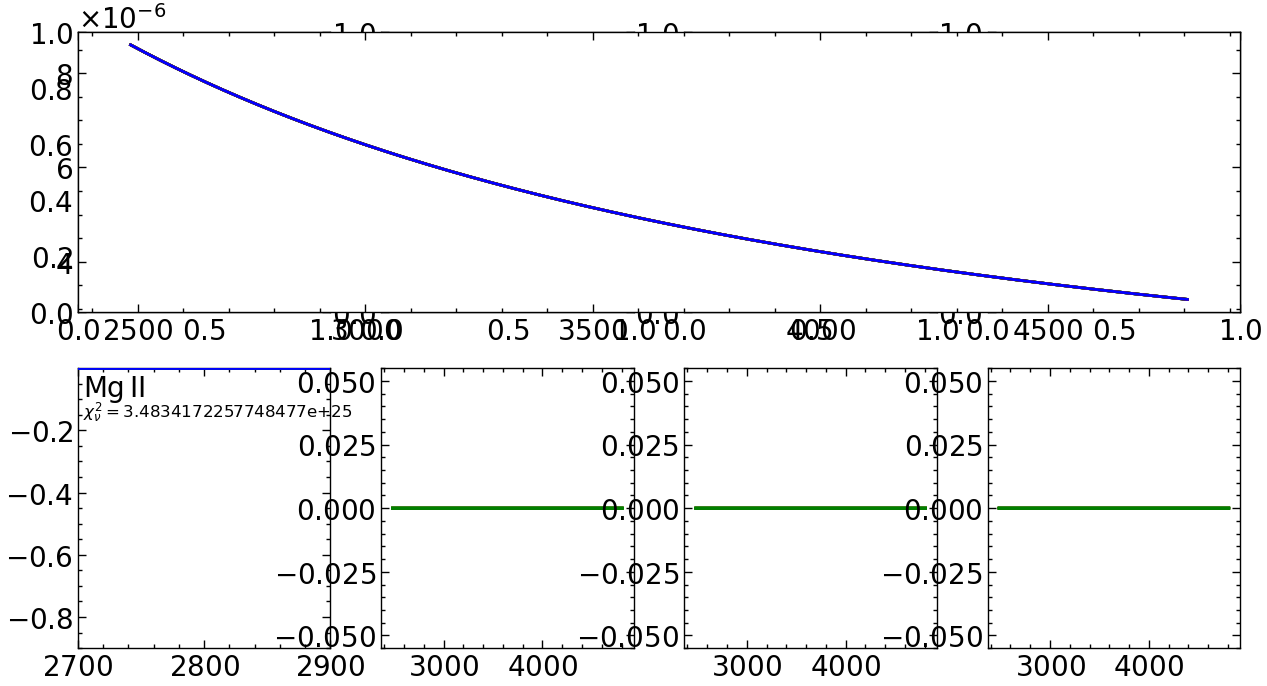

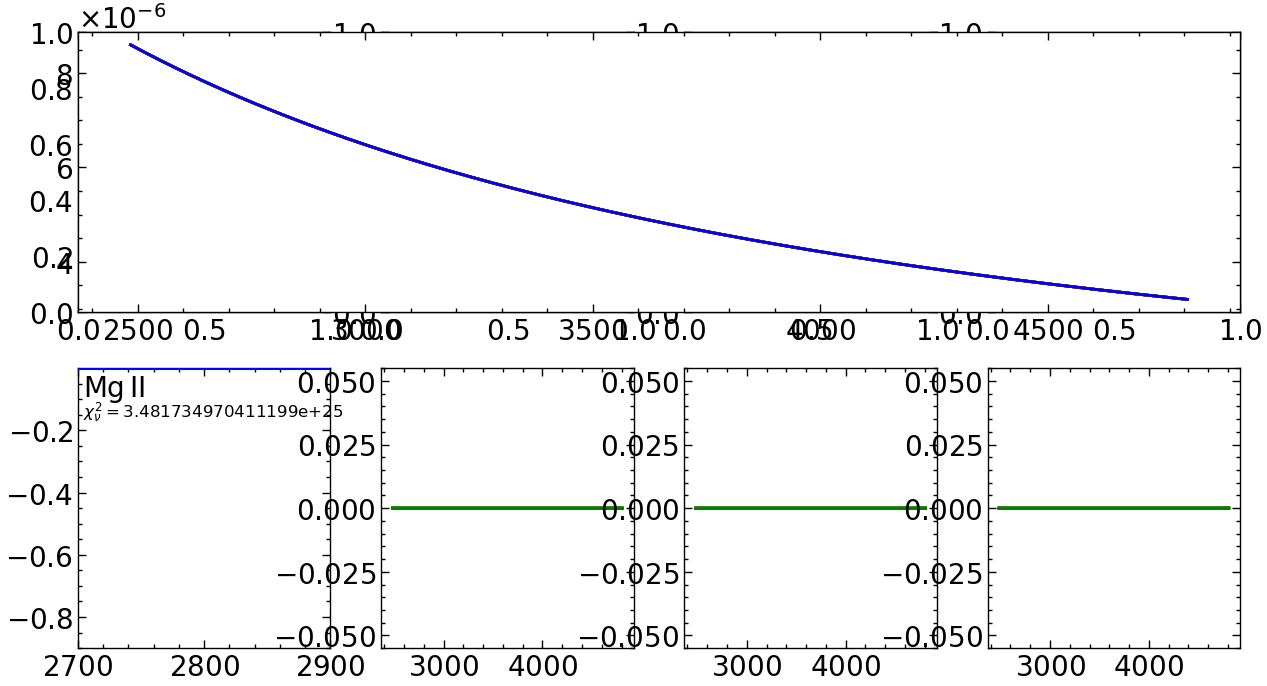

1350 ['-1.0']
1450 ['-1.0']
2200 ['44.13053541229976']
3000 ['44.17386426204218']
4200 ['44.441298671439']
5100 ['44.70470689143972']
Lconti 44.70470689143972
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 3530.493703264765
snr 0.0005950247392890587
20
20
Hb 2944.749888603032
snr 0.07698752077404675
20
20
Hb 0
snr 0
20
20
Hb 2834.3985289211514
snr 0.3126458306563677
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 3522.5774539511667
snr 0.006992557000457385
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 2984.7741507768064
snr 0.07763933018389345
20
20
Hb 0
snr 0
20
20
Hb 3529.1373926384153
snr 0.0004713569059104335
20
20
MgII 4022.5227289089275
snr 1.5554236027436024
20
20
MgII 7810.769051493051
snr 1.4123497943825702
20
20
MgII 4531.861491849255
snr 1.5798218614655715
20
20
MgII 3850.5523373480096
snr 1.860986965725372
20
20
MgII 3712.371789088316
snr 1.8811416667148442
20
20
MgII 3659.413517052432

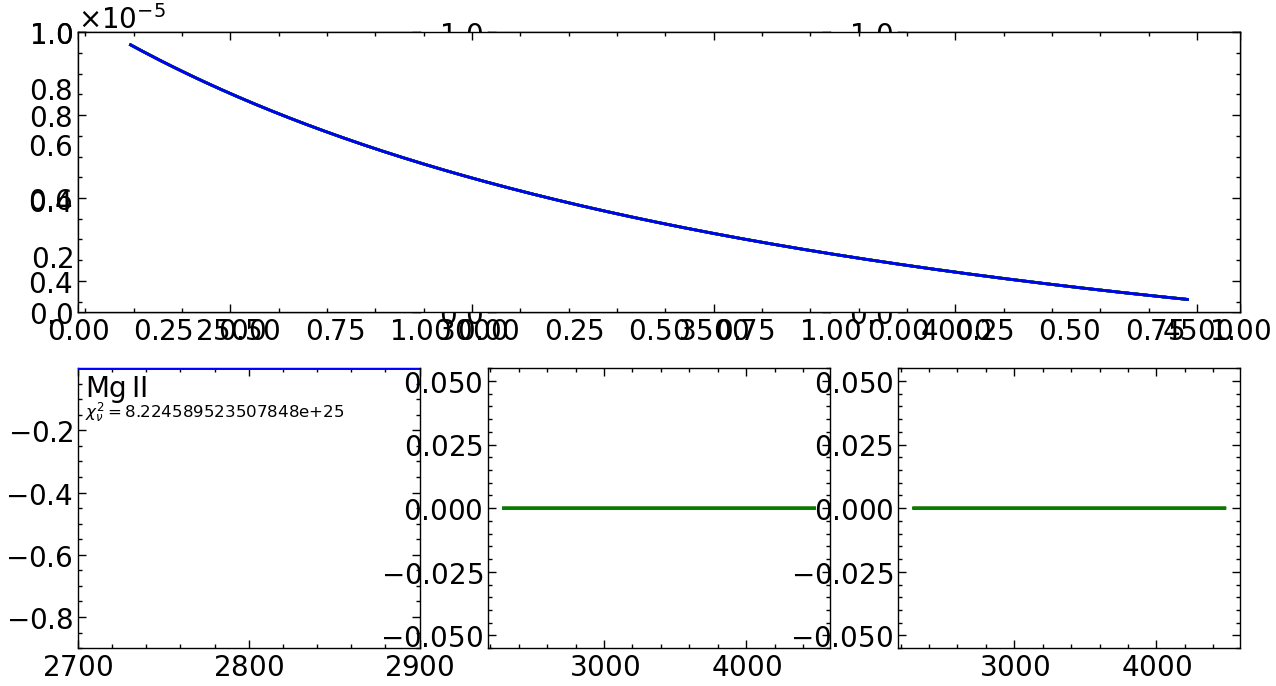

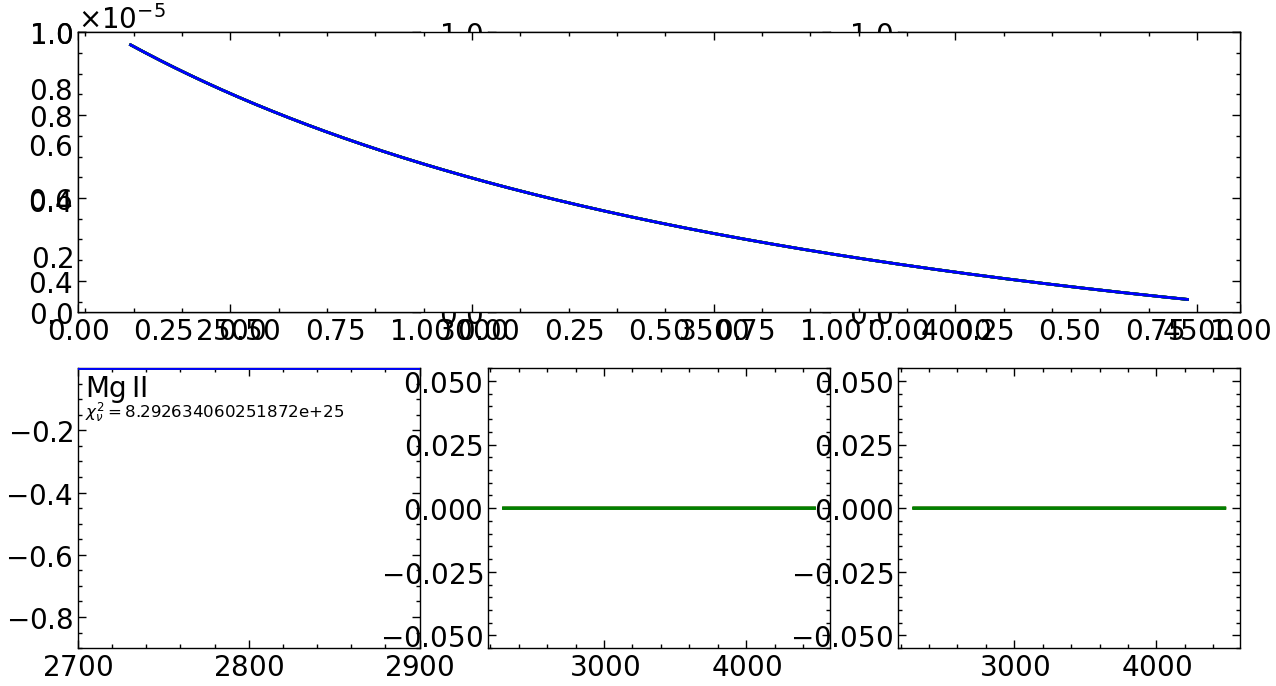

1350 ['-1.0']
1450 ['-1.0']
2200 ['44.67334132574893']
3000 ['44.64957599816054']
4200 ['44.53813155850699']
5100 ['-1.0']
Lconti 44.53813155850699
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
20
20
MgII 5687.376520711709
snr 1.146056246513968
20
20
MgII 3608.085320165811
snr 1.4219130404604898
20
20
MgII 7235.183091264509
snr 0.8352413314489109
20
20
MgII 22878.48791566661
snr 0.6423267056868115
20
20
MgII 23554.105818324908
snr 0.7133827455519081
20
20
MgII 20873.159502150724
snr 0.6593055779619985
20
20
MgII 22916.274678707003
snr 0.7819484940486506
20
20
MgII 6950.170007280681
snr 1.1117582007796736
20
20
MgII 19519.654779314176
snr 0.781574683144521
20
20
MgII 6769.931007532707
snr 1.1032623427835746
20
20
MgII 4030.151282988191
snr 1.227478532505143
20
20
MgII 3727.098322491096
snr 1.3044798201454624
20
20
M

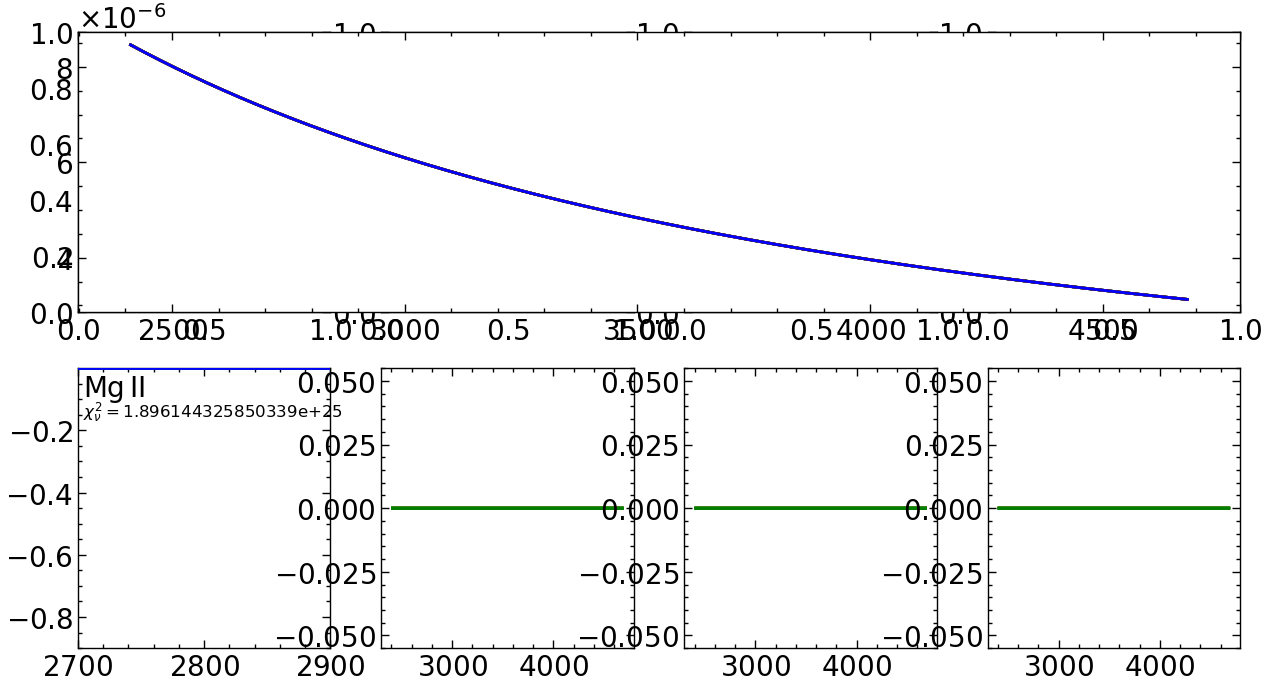

1350 ['-1.0']
1450 ['-1.0']
2200 ['-1.0']
3000 ['38.877347788522016']
4200 ['38.80428377858302']
5100 ['-1.0']
Lconti 38.80428377858302
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
MgII 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
CIV 0
snr 0
[]
[]
[]
MASS
643 has a 

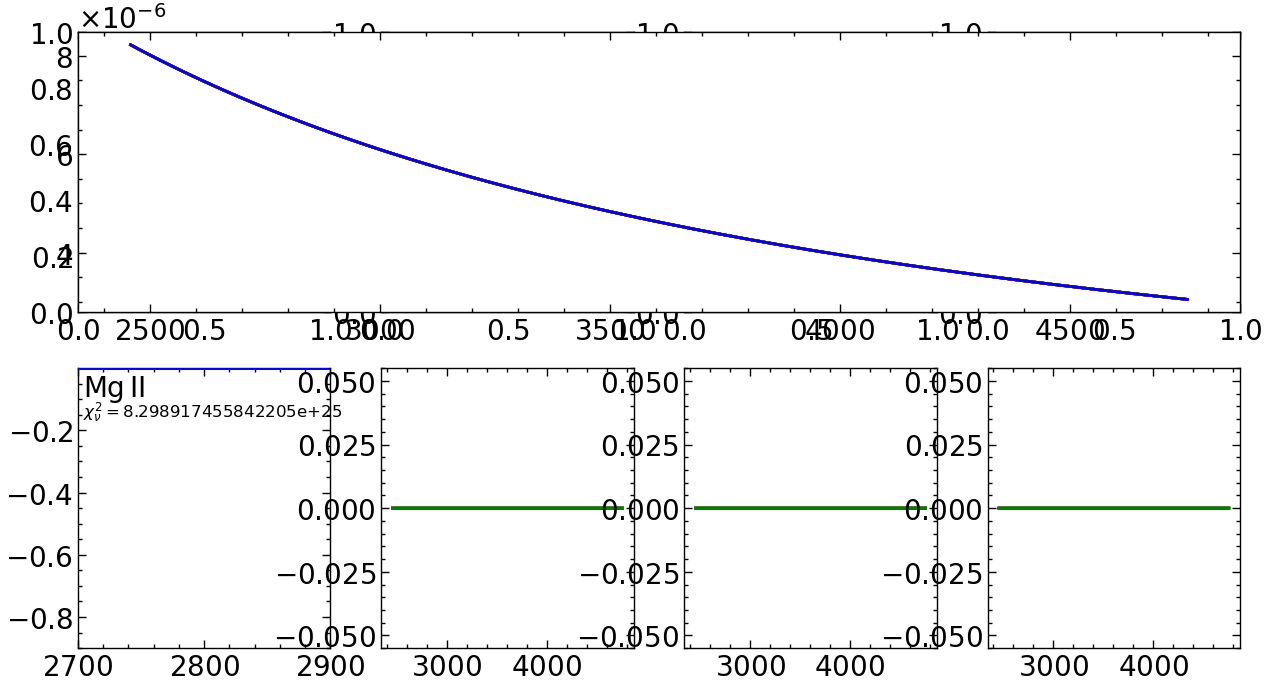

1350 ['-1.0']
1450 ['-1.0']
2200 ['44.5830061258196']
3000 ['44.48429316466606']
4200 ['44.21921852489512']
5100 ['-1.0']
Lconti 44.21921852489512
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
Hb 0
snr 0
20
20
MgII 4117.9012341552025
snr 1.5306781472381743
20
20
MgII 6745.903478209787
snr 1.0338600936038662
20
20
MgII 5174.772587122323
snr 1.149587465410271
20
20
MgII 5798.689076036069
snr 1.250496403927286
20
20
MgII 4117.825084527409
snr 1.5615138240025899
20
20
MgII 3651.737315791501
snr 1.7095592043235086
20
20
MgII 4650.814481371587
snr 1.2478270150757265
20
20
MgII 5500.209659090871
snr 1.572805619707875
20
20
MgII 3142.4297691541988
snr 1.700221179820236
20
20
MgII 3537.713938337845
snr 1.8496549379655518
20
20
MgII 7072.148146458016
snr 1.2293066070361924
20
20
MgII 3818.555601205232
snr 1.0993295292001684
20
20
MgII 

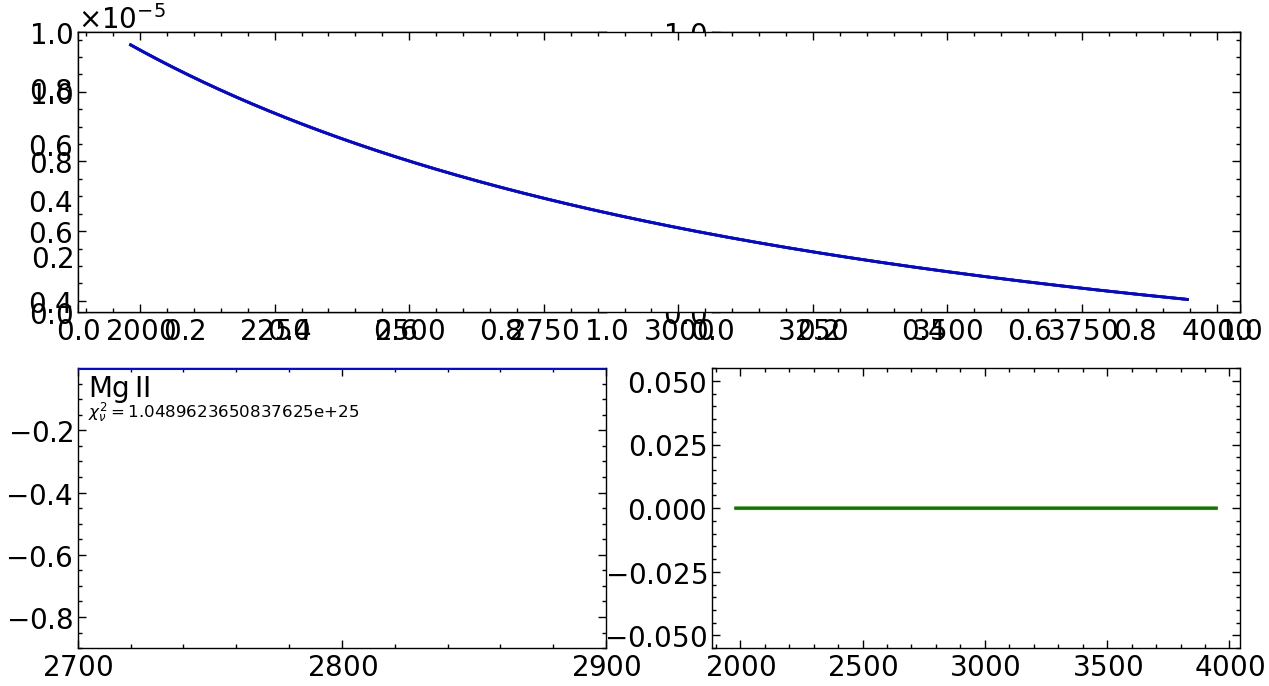

1350 ['-1.0']
1450 ['-1.0']
2200 ['44.2301919260058']
3000 ['44.17352953497784']
4200 ['44.201115332965735']
5100 ['44.65523825640685']
Lconti 44.65523825640685
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
Hb 0
snr 0
20
20
MgII 3476.1060837424147
snr 1.7594879699849164
20
20
MgII 4713.371505999511
snr 1.051023213173537
20
20
MgII 6623.902124456971
snr 1.3295798626956234
20
20
MgII 3393.9351582268655
snr 1.3624147854942945
20
20
MgII 2894.4399031363896
snr 1.7606674319092728
20
20
MgII 3568.069637340824
snr 1.549895281215302
20
20
MgII 3344.183769797961
snr 1.606116616103836
20
20
MgII 2934.0786776565037
snr 1.5842010195798881
20
20
MgII 3223.7095882165927
snr 1.6066501299536766
20
20
MgII 3249.7643871035857

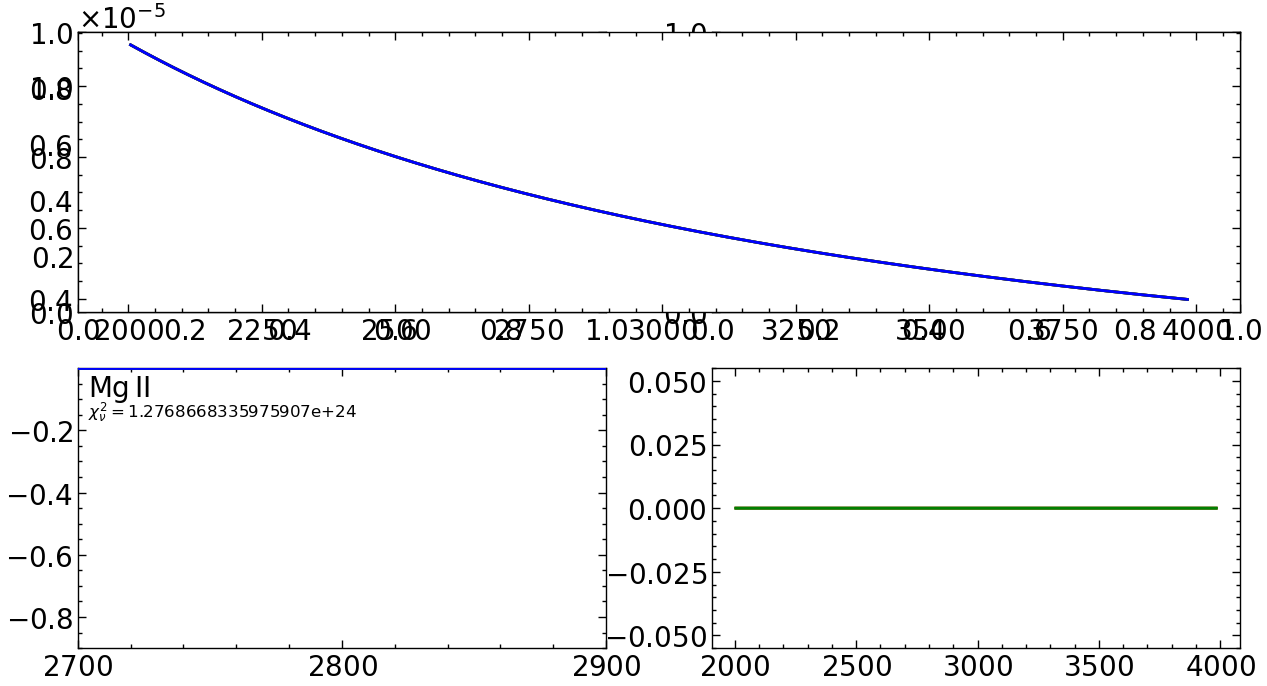

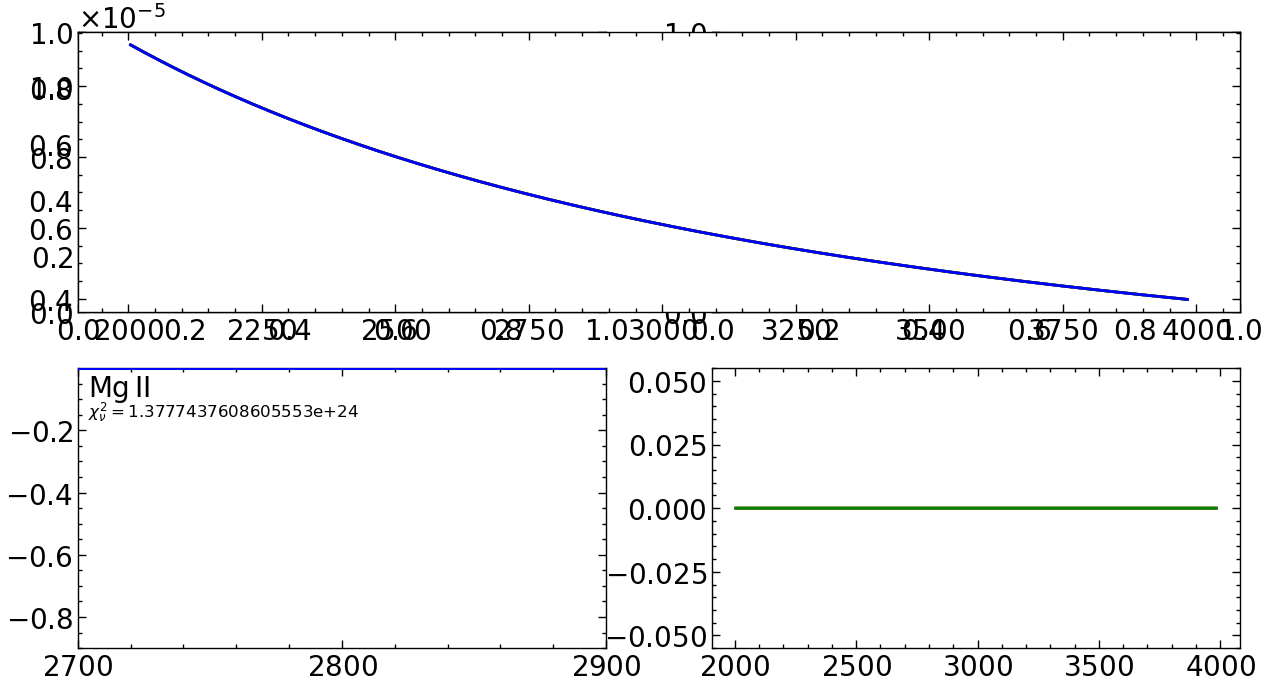

1350 ['-1.0']
1450 ['-1.0']
2200 ['-1.0']
3000 ['44.0925754416653']
4200 ['43.90229751920493']
5100 ['43.850954570694036']
Lconti 43.850954570694036
20
20
Hb 5763.338161923156
snr 0.5354636017844245
20
20
Hb 0
snr 0
20
20
Hb 6269.678807856011
snr 0.29750126954514505
20
20
Hb 2827.5525423458075
snr 0.5229026573726746
20
20
Hb 2833.37769073184
snr 0.6231613845136695
20
20
Hb 2826.136379151246
snr 1.1979755940612613
20
20
Hb 2833.0824897241805
snr 0.24918219843794379
20
20
Hb 2827.982920174871
snr 0.458237530346569
20
20
Hb 4404.257511430831
snr 0.312257143288882
20
20
Hb 10852.036322793178
snr 0.3073494150606307
20
20
Hb 2797.025853141553
snr 0.3957253979056163
20
20
Hb 2832.040117439864
snr 0.08420703762406645
20
20
Hb 2829.8457558048585
snr 0.6180944563271854
20
20
Hb 2832.3858037638033
snr 0.5148899675060169
20
20
Hb 2828.8432981703368
snr 0.4202207082686236
20
20
Hb 2824.5899890831106
snr 0.5810115645444446
20
20
Hb 3512.5667166371063
snr 0.8310012786953893
20
20
Hb 2826.642580449863

In [139]:
for i,ID in enumerate(data_agn_updated['ID']):
    flag = 0

    print('ID::', ID)

    #Test individual ID's (Comment out for normal running)
    #if ID != 47: 
    #   continue
    
    ra = data_agn_updated['RA'][i]
    dec = data_agn_updated['dec'][i]

    z = data_agn_updated['z_best'][i]

    ##### TODO: FIx table entries w/ z=-1!! ???????
    if z < 0:
        continue

    src = -1
    
    # GAMA
    if os.path.isfile('spec/GAMA/GAMA_%d.fit'%ID): 

        src = 1

        print(f'{ID} has a GAMA spectra, z = {z}')

        hdul_gama = fits.open('spec/GAMA/GAMA_%d.fit'%ID)
        header = hdul_gama[0].header
        data = hdul_gama[0].data
        flux = data[0]
        flux_err = data[1]
        mask = np.isfinite(flux) & np.isfinite(flux_err)

        w = WCS(header, naxis=1, relax=False, fix=False)

        wave = w.wcs_pix2world(np.arange(len(flux)), 0)[0]

        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)
    


    # Keck B
    if os.path.isfile('spec/Keck/keck_%d.fits'%ID): 

        src = 2

        print(f'{ID} has a Keck B spectra, z = {z}')

        hdul = fits.open('spec/Keck/keck_%d.fits'%ID)
        flux = hdul[1].data['SPEC'][0]
        wave = hdul[1].data['LAMBDA'][0]
        ivar = hdul[1].data['IVAR'][0]
        flux_err = 1/np.sqrt(ivar)

        mask = np.isfinite(flux) & np.isfinite(flux_err)

        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)

    # Keck R
    if os.path.isfile('spec/Keck/keck_%d.fits'%ID): 

        src = 3

        print(f'{ID} has a Keck R spectra, z = {z}')

        hdul = fits.open('spec/Keck/keck_%d.fits'%ID)
        flux = hdul[2].data['SPEC'][0]
        wave = hdul[2].data['LAMBDA'][0]
        ivar = hdul[2].data['IVAR'][0]
        flux_err = 1/np.sqrt(ivar)

        mask = np.isfinite(flux) & np.isfinite(flux_err)

        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)



    # VIPERS PDR1
    if os.path.isfile('spec/VIPERS_W1_PDR1/VIPERS_%d.fits'%ID): 

        src = 4

        print(f'{ID} has a PDR 1 spectra, z = {z}')


        hdul_vipers = fits.open('spec/VIPERS_W1_PDR1/VIPERS_%d.fits'%ID)
        data_vipers = hdul_vipers[1].data

        flux = data_vipers['FLUXES']
        flux_err = data_vipers['NOISE']
        #flux_err = np.full_like(flux, median_abs_deviation(flux, scale='normal', nan_policy='omit'))
        wave = data_vipers['WAVES']

        mask = np.isfinite(flux) & np.isfinite(flux_err)
        

        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)



    # VIPERS PDR2
    if os.path.isfile('spec/VIPERS_W1_PDR2/VIPERS_%d.fits'%ID): 

        src = 5

        print(f'{ID} has a PDR 2 spectra, z = {z}')

        hdul_vipers = fits.open('spec/VIPERS_W1_PDR2/VIPERS_%d.fits'%ID)
        data_vipers = hdul_vipers[1].data

        flux = data_vipers['FLUXES']
        flux_err = data_vipers['NOISE']
        wave = data_vipers['WAVES']

        mask = np.isfinite(flux) & np.isfinite(flux_err)
        
        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)

        

                
    # SDSS
    if os.path.isfile('spec/SDSS/sdss_%d.fits'%ID): 

        print(f'{ID} has a SDSS spectra, z = {z}')
        
        src = 6
        
        hdu = fits.open('spec/SDSS/sdss_%d.fits'%ID)
        wave = 10**hdu[1].data['loglam']
        flux = hdu[1].data['flux']
        flux_err = 1/np.sqrt(hdu[1].data['ivar'])
        mask = np.isfinite(flux) & np.isfinite(flux_err)

        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)





    # DESI
    if os.path.isfile('spec/desi/desi_%d.txt'%ID):

        src = 7

        print(f'{ID} has a DESI spectra, z = {z}')
        
        data_spec = ascii.read('spec/desi/desi_%d.txt'%ID)

        wave = data_spec['col1']
        flux = data_spec['col2']
        flux_err = 1/np.sqrt(data_spec['col3'])

        mask = np.isfinite(flux) & np.isfinite(flux_err)
        
        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)




    # OzDES _x5700

    if os.path.isfile('spec/ozdes/ozdes_%d_x5700.fits'%ID):

        src = 8

        print(f'{ID} has a x5700 spectra, z = {z}')
                
        hdul_ozdes = fits.open('spec/ozdes/ozdes_%d_x5700.fits'%ID)

        header = hdul_ozdes[0].header
        flux = hdul_ozdes[0].data
        flux_err = hdul_ozdes[1].data
        w = WCS(header, naxis=1, relax=False, fix=False)
        wave = w.wcs_pix2world(np.arange(len(flux)), 0)[0]

        print('mask')
        print(hdul_ozdes[2].data)

        mask = np.isfinite(flux) & np.isfinite(flux_err) & (hdul_ozdes[2].data==0)

        #crval1 = header['CRVAL1']
        #cdelt1 = header['CDELT1']
        #crpix1 = header['CRPIX1']

        #n_pixels = len(flux)
        #wave = crval1 + cdelt1 * (np.arange(n_pixels) + 1 - crpix1)

        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)




    # OzDES _x5700_x6700

    if os.path.isfile('spec/ozdes/ozdes_%d_x5700_x6700.fits'%ID):
        
        src = 9

        print(f'{ID} has a x5700x6700 spectra, z = {z}')
                
        hdul_ozdes = fits.open('spec/ozdes/ozdes_%d_x5700_x6700.fits'%ID)

        header = hdul_ozdes[0].header
        flux = hdul_ozdes[0].data
        flux_err = hdul_ozdes[1].data
        w = WCS(header, naxis=1, relax=False, fix=False)
        wave = w.wcs_pix2world(np.arange(len(flux)), 0)[0]

        mask = np.isfinite(flux) & np.isfinite(flux_err)

        #crval1 = header['CRVAL1']
        #cdelt1 = header['CDELT1']
        #crpix1 = header['CRPIX1']

        #n_pixels = len(flux)
        #wave = crval1 + cdelt1 * (np.arange(n_pixels) + 1 - crpix1)

        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)



    #OzDES _x6700

    if os.path.isfile('spec/ozdes/ozdes_%d_x6700.fits'%ID):
        
        src = 10

        print(f'{ID} has a x6700 spectra, z = {z}')
                
        hdul_ozdes = fits.open('spec/ozdes/ozdes_%d_x6700.fits'%ID)

        header = hdul_ozdes[0].header
        flux = hdul_ozdes[0].data
        flux_err = hdul_ozdes[1].data
        w = WCS(header, naxis=1, relax=False, fix=False)
        wave = w.wcs_pix2world(np.arange(len(flux)), 0)[0]

        mask = np.isfinite(flux) & np.isfinite(flux_err)

        #crval1 = header['CRVAL1']
        #cdelt1 = header['CDELT1']
        #crpix1 = header['CRPIX1']

        #n_pixels = len(flux)
        #wave = crval1 + cdelt1 * (np.arange(n_pixels) + 1 - crpix1)

        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux, flux_err)
    
    # CDFS

    #if os.path.isfile('spec/CDFS/cdfs_%d.fits'%ID):

        #src = 11

        #print(f'{ID} has a CDFS spectra, z = {z}')

        #hdul = fits.open('spec/CDFS/cdfs_%d.fits'%ID)
        #header = hdul[0].header
        #flux = hdul[0].data
        #flux_err = TODO: add MAD
        #w = WCS(header, naxis=1, relax=False, fix=False)
        #wave = w.wcs_pix2world(np.arange(len(flux)), 0)[0]

        #mask = np.isfinite(flux) & np.isfinite(flux_err)

        # FLUX CALIBR
        #flux, flux_err, flag = flux_calib(ID, wave[mask], flux[mask], flux_err[mask], src)
        #data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        #measureMBH(ID, src, z, wave[mask], flux, flux_err)

### Check if any AGN had errors while fitting

In [22]:
print(len(np.unique(bad_ID)))

bad_ID

0


[]

In [24]:
data_agn_BH

ID,SNR,src,flag_cal,f_conti,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_line,M_line_e,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-1,-1.0,-1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,44.481238935172975,8,1,1.9241770302187668,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.256985023313874,44.968792252355065,8.377118971671159,8.56794032548359,0.009730340401817727,nan,8.377118971671159,nan,nan,8.56794032548359,nan,nan,0.010680848603734217,nan,nan,0.009730340401817727,nan
9,-0.11749330723547038,10,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.361238173490925,44.07304540253212,-1.0,-1.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10,0.11226613323192566,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.43643921920578,44.14824644824697,7.268388754705876,8.477607032364721,nan,nan,nan,7.268388754705876,nan,nan,8.477607032364721,nan,nan,nan,nan,nan,nan
10,0.5618919687610074,9,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.56653543841239,44.27834266745358,7.334878290572327,8.225884975382789,nan,nan,nan,7.334878290572327,nan,nan,8.225884975382789,nan,nan,nan,nan,nan,nan
32,0.11863899435750129,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.30911276122775,44.02091999026894,-1.0,-1.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
32,0.14468519167092342,9,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.461880776050045,44.173688005091236,-1.0,-1.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
43,15.897378836853427,8,1,3.4568088471521046,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.52422089194013,45.236028120981324,8.952602133105009,9.080270121745622,0.13413434651067496,nan,8.952602133105009,nan,nan,9.080270121745622,nan,nan,0.13787921713095447,nan,nan,0.13413434651067496,nan
44,26.475011831685606,8,1,89.4495218589778,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.728603934258864,45.309528909934485,9.214891535795257,8.91366511675681,0.07297503904840527,9.214891535795257,8.886619548243598,nan,8.91366511675681,8.866639049856955,nan,0.05278107273878618,0.006229254899384905,nan,0.07297503904840527,0.005921894153479718,nan


### Save the results:

In [141]:
if flux_cal:
    ascii.write(data_agn_BH, 'data_agn_BH_fluxed.dat', overwrite=True)
else:
    ascii.write(data_agn_BH, 'data_agn_BH.dat', overwrite=True)

In [175]:
#flux_cal = True

In [176]:
print(flux_cal)

True


### Read the correct file (calibrated vs non-calibrated)

In [177]:
if flux_cal:
    data_agn_BH = ascii.read('data_agn_BH_fluxed.dat')
else:
    data_agn_BH = ascii.read('data_agn_BH.dat')

In [178]:
# Only keep those with good flux calibration
data_agn_BH_cal = data_agn_BH[data_agn_BH['flag_cal']==1]
# First, keep the spectra with at least one valid BH mass
# Keep best SNR spectrum
data_agn_BH_tmp = data_agn_BH_cal[data_agn_BH_cal['M']>0].to_pandas()
#data_agn_BH_tmp = data_agn_BH_cal.to_pandas()
data_agn_BH_tmp = data_agn_BH_tmp.loc[data_agn_BH_tmp.groupby('ID')['SNR'].idxmax()]
data_agn_BH_best = table.Table.from_pandas(data_agn_BH_tmp)
data_agn_BH_best

ID,SNR,src,flag_cal,f_conti,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_line,M_line_e,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
6,44.481238935172975,8,1,1.9241770302187668,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.256985023313874,44.968792252355065,8.377118971671159,8.56794032548359,0.009730340401817727,--,8.377118971671159,--,--,8.56794032548359,--,--,0.010680848603734217,--,--,0.009730340401817727,--
10,0.5618919687610074,9,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.56653543841239,44.27834266745358,7.334878290572327,8.225884975382789,--,--,--,7.334878290572327,--,--,8.225884975382789,--,--,--,--,--,--
43,15.897378836853427,8,1,3.4568088471521046,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.52422089194013,45.236028120981324,8.952602133105009,9.080270121745622,0.13413434651067496,--,8.952602133105009,--,--,9.080270121745622,--,--,0.13787921713095447,--,--,0.13413434651067496,--
44,26.475011831685606,8,1,89.4495218589778,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.728603934258864,45.309528909934485,9.214891535795257,8.91366511675681,0.07297503904840527,9.214891535795257,8.886619548243598,--,8.91366511675681,8.866639049856955,--,0.05278107273878618,0.006229254899384905,--,0.07297503904840527,0.005921894153479718,--
47,1.6722571947520826,2,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.69903305028332,44.665644036965254,7.5906962986903626,8.053820654885616,0.1093888262368035,--,7.5906962986903626,--,--,8.053820654885616,--,--,0.05546672818925326,--,--,0.1093888262368035,--
56,1.1571526681670206,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.53731159985643,45.24911882889762,8.529899797135478,8.638970736513278,0.12201882370042991,--,8.529899797135478,--,--,8.638970736513278,--,--,0.09458553573369463,--,--,0.12201882370042991,--
60,51.778343709807366,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.86211418448649,45.57392141352768,9.133908905110586,9.006429121037275,0.012624507492205577,--,9.133908905110586,--,--,9.006429121037275,--,--,0.014501189535426619,--,--,0.012624507492205577,--
66,50.08060057944602,8,1,60.356609712825836,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.756875581599054,45.337800557274676,8.449331629206686,8.331508844301815,0.04676003317127717,8.449331629206686,8.264544273335858,--,8.331508844301815,8.068766034365103,--,0.04509084226371215,0.00015276406500887922,--,0.04676003317127717,0.00011963268715498697,--
67,0.5845627534111119,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,42.21321618745141,42.79414116312703,6.541295014713498,6.982295944342676,--,--,6.541295014713498,--,--,6.982295944342676,--,--,--,--,--,--,--


In [179]:
data_agn_BH[(data_agn_BH['ID']==290)]

ID,SNR,src,flag_cal,f_conti,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_line,M_line_e,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


### Analyze

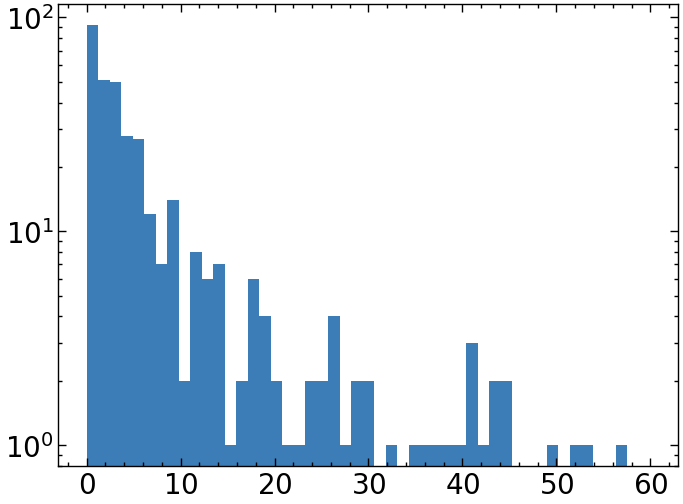

In [180]:

plt.hist(data_agn_BH['SNR'], label='3000', alpha=0.8, bins=np.linspace(0, 60), log=True);

In [181]:
#data_agn_BH['SNR']

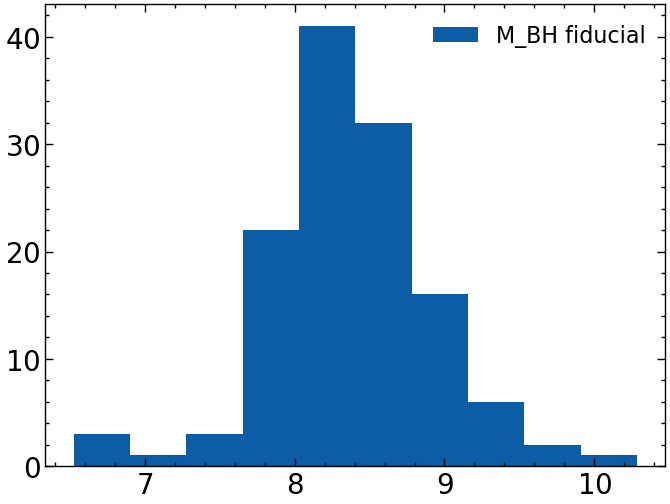

In [182]:
plt.hist(data_agn_BH_best['M'][data_agn_BH_best['M']>0], label='M_BH fiducial')
plt.legend()

0.6404385659179098


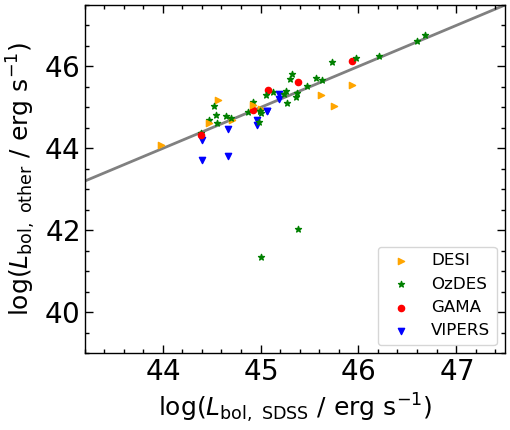

In [183]:
mask_sdss = data_agn_BH['src']==6
dms = []
fig, ax = plt.subplots(1,1, figsize=(5.3, 4.5))

## TODO: throw out ones with galaxy > Lconti AGN

## TODO: right the sources in order

colors = ['k', 'red', 'gray', 'coral', 'blue', 'blue', 'pink', 'orange', 'green', 'green', 'green']
#colors = ['k', 'k', 'gray', 'coral', 'dodgerblue', 'pink', 'orange', 'orange', 'k']

labels = ['', 'GAMA', 'Keck B', 'Keck R', 'VIPERS', 'VIPERS', 'SDSS', 'DESI', 'OzDES', 'OzDES', 'OzDES']
markers = ['', 'o', 's', '*', 'v', 'v', '<', '>', '*', '*', '*']
#markers = ['', 'o', 's', '*', 'v', '^', '<', '>', 'P']

x = np.linspace(41, 49)
ax.plot(x, x, color='gray', zorder=-1)
#ax.plot(x, x-0.2, color='k', linestyle='dashed', zorder=-1)
#ax.plot(x, x+0.2, color='k', linestyle='dashed', zorder=-1)

dm_store = []

for id in data_agn_BH['ID'][mask_sdss]:
    mask = (data_agn_BH['ID']==id)
    # SDSS
    m_sdss = data_agn_BH['Lbol'][mask & mask_sdss]
    # non-SDSS
    m_matches = data_agn_BH['Lbol'][mask & ~mask_sdss]
    src_matches = data_agn_BH['src'][mask & ~mask_sdss]
    #print(src_matches)
    for i, dmi in enumerate(m_matches):
        if dmi > 0:
            if (flux_cal==False) or (flux_cal==True and data_agn_BH['flag_cal'][mask & ~mask_sdss][i]==1):
                ax.scatter(m_sdss, dmi, color=colors[src_matches[i-1]], label=labels[src_matches[i-1]], marker=markers[src_matches[i-1]], s=20)
                dm_store.append(np.abs(dmi - m_sdss))

ax.set_xlabel(r'$\log(L_{\rm{bol,\ SDSS}}\ /\ \rm{erg\ s}^{-1})$', fontsize=18)
ax.set_ylabel(r'$\log(L_{\rm{bol,\ other}}\ /\ \rm{erg\ s}^{-1})$', fontsize=18)

print(np.std(dm_store))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=12, frameon=True, loc=4)

ax.set_xlim(43.2, 47.5)
ax.set_ylim(39, 47.5)

fig.tight_layout()
if flux_cal:
    fig.savefig('Lbol_fluxed.pdf', dpi=300)
else:
    fig.savefig('Lbol.pdf', dpi=300)

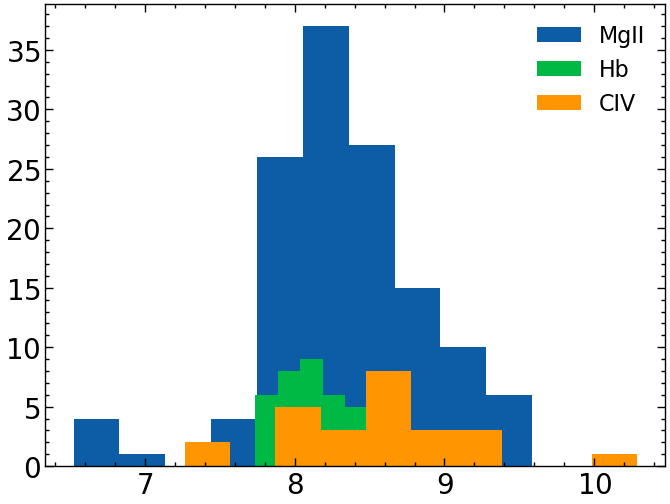

In [184]:
plt.hist(data_agn_BH['M_MgII'][data_agn_BH['M_MgII']>0], label='MgII')
plt.hist(data_agn_BH['M_Hb'][data_agn_BH['M_Hb']>0], label='Hb')
plt.hist(data_agn_BH['M_CIV'][data_agn_BH['M_CIV']>0], label='CIV')
plt.legend()

### Host Mass relation

#### Important: I changed all `z` to `z_best` 

#### Important: From here on out, use flux-calibrated file for best results

9.0
11.1
10.6
11.4
11.6
11.2
11.5
10.5
10.8
10.9
11.6


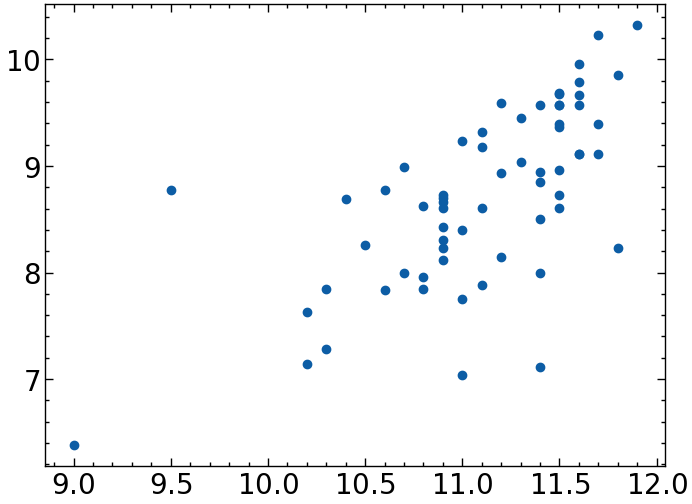

In [262]:
data_sed_elliptical = ascii.read('elliptical_agn.txt')

condition = data_sed_elliptical['$M_*$']=='\\nodata'
rows_to_delete = np.where(condition)[0]
data_sed_elliptical.remove_rows(rows_to_delete)

mask_elliptical = (data_sed_elliptical['HT']=='E')

data_sed_elliptical['$M_*$'] = data_sed_elliptical['$M_*$'].astype(float)

plt.scatter(data_sed_elliptical['$M_*$'][mask_elliptical], np.log10(data_sed_elliptical['$M_{\\rm BH}$'][mask_elliptical]))

#plt.xlim(8,12)



data_sed_elliptical['$M_*$'][mask_elliptical]


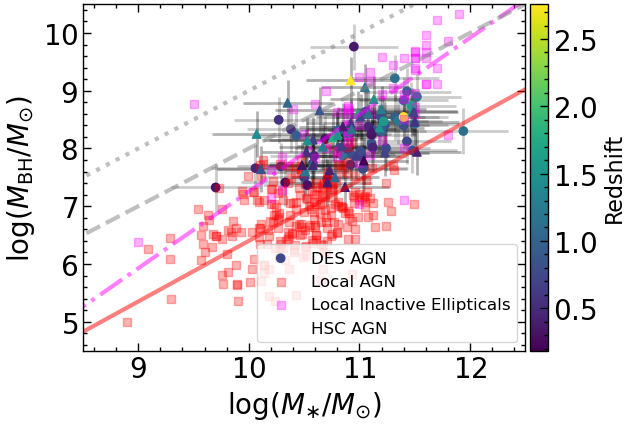

In [274]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# DES AGN
data_sed_des = ascii.read('table_mass.txt')
data_join_des = table.join(data_sed_des, data_agn_BH_best, keys='ID')
data_join_des = table.join(data_agn_updated, data_join_des, keys='ID')
cat_join = SkyCoord(data_join_des['RA'], data_join_des['dec'], unit='deg')
mask_chi2 = (data_join_des['SF_excess'] > 1.2) & (data_join_des['chi2'] < 5) # This selects against very luminous AGNs / high BHs or non SF galaxies

# Local AGN
data_sed_local = ascii.read('rv15.txt')

# Local Inactive Ellipticals
data_sed_elliptical = ascii.read('elliptical_agn.txt')

condition = data_sed_elliptical['$M_*$']=='\\nodata'
rows_to_delete = np.where(condition)[0]
data_sed_elliptical.remove_rows(rows_to_delete)

data_sed_elliptical['$M_*$'] = data_sed_elliptical['$M_*$'].astype(float)

mask_elliptical = (data_sed_elliptical['HT']=='E')

# HSC AGN
data_sed_hsc = ascii.read('hsc_agn_prop.txt')
mask_hsc = (data_sed_hsc['SF_excess'] > 1.2) & (data_sed_hsc['chi2nu'] < 5) # This selects against very luminous AGNs / high BHs or non SF galaxies



fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

#
x = np.logspace(8, 13)
ax.plot(np.log10(x), 7.45 + 1.05*np.log10(x/1e11), lw=3, 
        #label='local AGN',
        alpha = 0.5,
        color='red')
ax.plot(np.log10(x), 7.89 + 1.33*np.log10(x/3e10), lw=3, 
        #label='local inactive\nellipticals', 
        alpha = 0.5,
        linestyle='dashdot', color='magenta')

ax.plot(np.log10(x), np.log10(x/10) , linestyle='dotted', color='gray', lw=3, 
        alpha = 0.5,
        #label=r'$M_{\ast}=10 M_{\rm{BH}}$'
        )
ax.plot(np.log10(x), np.log10(x/100), linestyle='dashed', color='gray', lw=3, 
        alpha = 0.5,
        #label=r'$M_{\ast}=100 M_{\rm{BH}}$'
        )





# DES AGN
im = ax.scatter(data_join_des['logMs'][mask_chi2], data_join_des['M_line'][mask_chi2], c=data_join_des['z_best'][mask_chi2],
                label = 'DES AGN',
                marker='o')

ax.errorbar(data_join_des['logMs'][mask_chi2], data_join_des['M_line'][mask_chi2], c='k', zorder=-1,
                 xerr=0.4, yerr=0.4, marker=None, linestyle='none', alpha=0.2)


# Local AGN
ax.scatter(data_sed_local['logM*'], data_sed_local['logMBH'], marker='s', alpha = 0.3, label = 'Local AGN', color = 'red')


# Local Inactive Ellipticals
### TODO: it looks like this data isn't in log, or its in different units, bc it isn't showing up in the plot
ax.scatter(data_sed_elliptical['$M_*$'][mask_elliptical], np.log10(data_sed_elliptical['$M_{\\rm BH}$'][mask_elliptical]), marker='s', color = 'magenta', alpha = 0.3, label = 'Local Inactive Ellipticals')


# HSC AGN
im = ax.scatter(data_sed_hsc['logMs'][mask_hsc], data_sed_hsc['logMBH'][mask_hsc], c=data_sed_hsc['z_best'][mask_hsc], marker='^', label = 'HSC AGN')

ax.errorbar(data_sed_hsc['logMs'][mask_hsc], data_sed_hsc['logMBH'][mask_hsc], c='k', zorder=-1,
                 xerr=0.4, yerr=0.4, marker=None, linestyle='none', alpha=0.3)




#ax.errorbar(data_join_des['logMs'][mask_chi2], data_join_des['M_CIV'][mask_chi2], yerr=0.4, xerr=0.4,  marker='o', linestyle='none', label='CIV')
#ax.errorbar(data_join_des['logMs'][mask_chi2], data_join_des['M_Hb'][mask_chi2], yerr=0.4, xerr=0.4,  marker='o', linestyle='none', label='Hb')
ax.legend(fontsize=12, frameon=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'Redshift')

ax.set_xlim(8.5, 12.5)
ax.set_ylim(4.5, 10.5)

ax.set_ylabel(r'$\log(M_{\rm{BH}} / M_{\odot})$', fontsize=20)
ax.set_xlabel(r'$\log(M_{\ast} / M_{\odot})$', fontsize=20)

#fig.tight_layout()
fig.savefig('hostrel.pdf', dpi=300)


# Color by redshift
# Check with Jennifers paper
# Seems consistent with Fabio's result https://arxiv.org/pdf/2308.12331.pdf

In [275]:
data_join_good = data_join_des[mask_chi2]

In [276]:
data_join_good[data_join_good['logMs'] < 10]

Name,RA,dec,g,SNR_1,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_desi,z_best,ID,comment,err_reason,logMs,logMs_e,SF_excess,chi2,SNR_2,src,flag_cal,f_conti,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_line,M_line_e,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64,float64,int64,str150,bool,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J003822.00-434437.71,9.5917,-43.7438,23.1,11.1,8.7,$7.4 \pm 0.6$,0.0,$2.4 \pm 0.6$,0.35,0.03,0.04,nan,None,0.9,nan,SN-E2,-1.0,--,-1.0,-1.0,0.35,374,--,False,9.7,0.1,1.6,2.5,0.6785110496303762,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,42.643760280559114,43.224685256234736,6.8099271756043,7.325267426387795,--,--,6.8099271756043,--,--,7.325267426387795,--,--,--,--,--,--,--


In [277]:
data_join_des[mask_chi2][(data_join_des['M_line'][mask_chi2] > 6) & (data_join_des['z_best'][mask_chi2] < 1)]

Name,RA,dec,g,SNR_1,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_desi,z_best,ID,comment,err_reason,logMs,logMs_e,SF_excess,chi2,SNR_2,src,flag_cal,f_conti,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_line,M_line_e,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64,float64,int64,str150,bool,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J032818.10-280747.81,52.0754,-28.1299,20.8,25.6,19.9,$10.2 \pm 0.6$,0.0,$3.2 \pm 0.6$,0.9,0.2,0.35,nan,None,0.7,nan,SN-C3,0.894,2017AJ....153..107T,0.8939099907875061,-1.0,0.8939099907875061,56,--,False,11.06,0.09,1.4,1.7,1.1571526681670206,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.53731159985643,45.24911882889762,8.529899797135478,8.638970736513278,0.12201882370042991,--,8.529899797135478,--,--,8.638970736513278,--,--,0.09458553573369463,--,--,0.12201882370042991,--
J032718.71-281857.94,51.828,-28.3161,18.9,25.6,19.8,$10.2 \pm 0.1$,2.3,$2.6 \pm 0.8$,0.65,0.1,0.20,nan,None,0.9,nan,SN-C3,0.634,2017AJ....153..107T,0.6335499882698059,-1.0,0.6335499882698059,66,--,False,10.38,0.12,1.5,0.9,50.08060057944602,8,1,60.356609712825836,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.756875581599054,45.337800557274676,8.449331629206686,8.331508844301815,0.04676003317127717,8.449331629206686,8.264544273335858,--,8.331508844301815,8.068766034365103,--,0.04509084226371215,0.00015276406500887922,--,0.04676003317127717,0.00011963268715498697,--
J033203.75-285245.97,53.0156,-28.8794,21.5,22.2,18.4,$9.9 \pm 0.6$,0.0,$2.4 \pm 0.8$,0.9,0.25,0.05,0.77,2dF,0.8,nan,SN-C3,0.768,2017AJ....153..107T,0.7706400156021118,-1.0,0.7706400156021118,115,--,False,10.5,0.23,1.3,0.8,4.434518998162349,8,1,3.028580476220455,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.91157545916147,44.62338268820266,7.767274100031919,7.4987402723472165,0.00658729454902406,7.767274100031919,--,--,7.4987402723472165,--,--,0.00012840779781601812,--,--,0.00658729454902406,--,--
J033320.02-275912.63,53.3334,-27.9868,21.5,22.1,18.4,$9.9 \pm 0.4$,0.0,$1.8 \pm 0.2$,0.65,0.4,0.30,0.6833,ACES,0.7,nan,SN-C3,0.683,2010ApJS..191..124S,-1.0,-1.0,0.683,130,--,False,10.27,0.17,1.3,0.8,8.271622393661357,2,1,2.4947383820193627,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.15601528301209,44.86782251205328,8.91238153709622,8.495341975938977,0.11743203829169424,--,8.91238153709622,--,--,8.495341975938977,--,--,0.09662253531958873,--,--,0.11743203829169424,--
J033137.70-284808.11,52.9071,-28.8023,21.4,25.1,19.5,$9.8 \pm 0.6$,0.1,$2.5 \pm 0.6$,0.85,0.15,0.30,nan,None,0.9,nan,SN-C3,0.862,2017AJ....153..107T,0.8616700172424316,-1.0,0.8616700172424316,167,--,False,10.82,0.22,1.3,1.5,7.557295246444445,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.15514801535058,44.866955244391775,7.95171849240923,8.006965853611444,0.0051053583577974435,--,7.95171849240923,--,--,8.006965853611444,--,--,0.0050015805775548644,--,--,0.0051053583577974435,--
J033310.00-282754.18,53.2917,-28.465,21.1,23.8,19.0,$9.7 \pm 0.5$,0.1,$1.8 \pm 0.2$,0.7,0.35,0.35,nan,None,0.8,nan,SN-C3,-1.0,--,0.6931099891662598,-1.0,0.6931099891662598,172,--,False,10.29,0.12,1.4,1.3,5.780788788731524,8,1,3.805118898409462,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.95098659296713,44.531911568642755,7.761813060560374,7.688705848688038,0.0524218994333201,--,7.761813060560374,--,--,7.688705848688038,--,--,0.039621361944770984,--,--,0.0524218994333201,--
J032912.09-273147.23,52.3004,-27.5298,23.4,9.1,9.5,$10.7 \pm 0.3$,0.6,$2.4 \pm 0.8$,1.01,0.02,0.03,nan,None,0.4,nan,SN-C3,-1.0,--,0.9680200219154358,-1.0,0.9680200219154358,213,--,False,11.04,0.08,2.2,0.3,2.5494254384952493,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1

In [278]:
data_join_des[mask_chi2][data_join_des['M_line'][mask_chi2] > 2]

Name,RA,dec,g,SNR_1,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_desi,z_best,ID,comment,err_reason,logMs,logMs_e,SF_excess,chi2,SNR_2,src,flag_cal,f_conti,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_line,M_line_e,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64,float64,int64,str150,bool,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J032818.10-280747.81,52.0754,-28.1299,20.8,25.6,19.9,$10.2 \pm 0.6$,0.0,$3.2 \pm 0.6$,0.9,0.2,0.35,nan,None,0.7,nan,SN-C3,0.894,2017AJ....153..107T,0.8939099907875061,-1.0,0.8939099907875061,56,--,False,11.06,0.09,1.4,1.7,1.1571526681670206,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.53731159985643,45.24911882889762,8.529899797135478,8.638970736513278,0.12201882370042991,--,8.529899797135478,--,--,8.638970736513278,--,--,0.09458553573369463,--,--,0.12201882370042991,--
J032718.71-281857.94,51.828,-28.3161,18.9,25.6,19.8,$10.2 \pm 0.1$,2.3,$2.6 \pm 0.8$,0.65,0.1,0.20,nan,None,0.9,nan,SN-C3,0.634,2017AJ....153..107T,0.6335499882698059,-1.0,0.6335499882698059,66,--,False,10.38,0.12,1.5,0.9,50.08060057944602,8,1,60.356609712825836,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.756875581599054,45.337800557274676,8.449331629206686,8.331508844301815,0.04676003317127717,8.449331629206686,8.264544273335858,--,8.331508844301815,8.068766034365103,--,0.04509084226371215,0.00015276406500887922,--,0.04676003317127717,0.00011963268715498697,--
J033203.75-285245.97,53.0156,-28.8794,21.5,22.2,18.4,$9.9 \pm 0.6$,0.0,$2.4 \pm 0.8$,0.9,0.25,0.05,0.77,2dF,0.8,nan,SN-C3,0.768,2017AJ....153..107T,0.7706400156021118,-1.0,0.7706400156021118,115,--,False,10.5,0.23,1.3,0.8,4.434518998162349,8,1,3.028580476220455,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.91157545916147,44.62338268820266,7.767274100031919,7.4987402723472165,0.00658729454902406,7.767274100031919,--,--,7.4987402723472165,--,--,0.00012840779781601812,--,--,0.00658729454902406,--,--
J033320.02-275912.63,53.3334,-27.9868,21.5,22.1,18.4,$9.9 \pm 0.4$,0.0,$1.8 \pm 0.2$,0.65,0.4,0.30,0.6833,ACES,0.7,nan,SN-C3,0.683,2010ApJS..191..124S,-1.0,-1.0,0.683,130,--,False,10.27,0.17,1.3,0.8,8.271622393661357,2,1,2.4947383820193627,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.15601528301209,44.86782251205328,8.91238153709622,8.495341975938977,0.11743203829169424,--,8.91238153709622,--,--,8.495341975938977,--,--,0.09662253531958873,--,--,0.11743203829169424,--
J032831.41-285249.82,52.1309,-28.8805,20.8,24.9,19.7,$10.1 \pm 0.4$,0.2,$3.1 \pm 0.6$,1.2,0.45,0.05,nan,None,1.2,nan,SN-C3,1.05,2017AJ....153..107T,1.0495500564575195,-1.0,1.0495500564575195,149,--,False,10.89,0.17,1.3,2.5,28.245764590389868,8,1,109.31601370084053,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.58164254973438,45.293449778775575,8.198496573643034,8.258517402120194,0.005221132374236101,--,8.198496573643034,--,--,8.258517402120194,--,--,0.005284364678854506,--,--,0.005221132374236101,--
J033211.42-284324.07,53.0476,-28.7234,22.4,23.8,19.1,$10.1 \pm 0.4$,0.2,$2.8 \pm 0.7$,1.35,0.05,0.20,1.2369,2dF,0.8,nan,SN-C3,1.238,2017AJ....153..107T,1.2360299825668335,-1.0,1.2360299825668335,155,--,False,11.4,0.05,1.3,2.0,11.77035499240108,8,1,inf,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.36288438525427,45.07469161429546,8.869070178988073,8.83124538619007,0.006438695648440308,--,8.869070178988073,--,--,8.83124538619007,--,--,0.005911131797717159,--,--,0.006438695648440308,--
J033137.70-284808.11,52.9071,-28.8023,21.4,25.1,19.5,$9.8 \pm 0.6$,0.1,$2.5 \pm 0.6$,0.85,0.15,0.30,nan,None,0.9,nan,SN-C3,0.862,2017AJ....153..107T,0.8616700172424316,-1.0,0.8616700172424316,167,--,False,10.82,0.22,1.3,1.5,7.5572952464

In [279]:
7.45 + 1.05*np.log10(3e10/1e11)

6.900977317455646

### Changed 'i-mag' to 'g' line 10

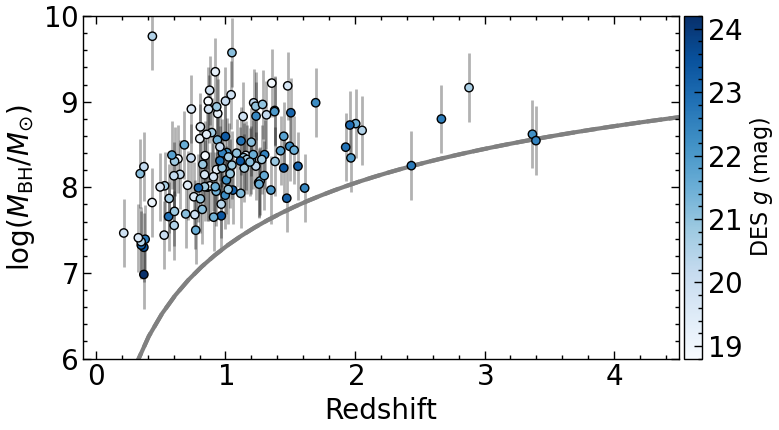

In [280]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

data_sed = ascii.read('table_mass.txt')
data_join = table.join(data_sed, data_agn_BH_best, keys='ID')
data_join = table.join(data_agn_updated, data_join, keys='ID')

fig, ax = plt.subplots(1,1, figsize=(8, 4.5))

im = ax.scatter(data_join['z_best'], data_join['M_line'],
                c=data_join['g'], cmap='Blues',
                marker='o', edgecolors='k', label='spec-z')

ax.errorbar(data_join['z_best'], data_join['M_line'],
            yerr=0.4, marker=None, linestyle='none', color='k', zorder=-1, alpha=0.3)


#ax.legend(loc=4, frameon=True)
ax.set_xlabel('Redshift', fontsize=20)
ax.set_ylabel(r'$\log(M_{\rm{BH}} / M_{\odot})$', fontsize=20)

ax.set_xlim(-.1, 4.5)
ax.set_ylim(6.0, 10)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'DES $g$ (mag)')

a = -4.7
b = -1.9
m5 = 24.5
gamma = 0.039
SFinf = 0.1
zs = np.linspace(0, 5)
d_pc = cosmo.luminosity_distance(zs).to(u.pc).value
alpha = 0.0 # for galaxies
K = -2.5*(1 + alpha) * np.log10(1 + zs) # K-correction
logM = 1/b*(2.5 * np.log10(SFinf * gamma**-1/2) - a - 5 * np.log10(d_pc) + 5 - K + m5 )

# BHs are much bigger compared to their hosts, so should outshine host more easily

ax.set_autoscale_on(False)
ax.plot(zs, logM, lw=3, color='gray', zorder=-1)
#ax.plot(zs, logM+0.7, lw=3, color='gray', zorder=-1)


ax.plot(zs, logM, lw=3, color='gray', zorder=-1, linestyle='dashed')


fig.tight_layout()
fig.savefig('bhmassredshift.pdf', dpi=300)

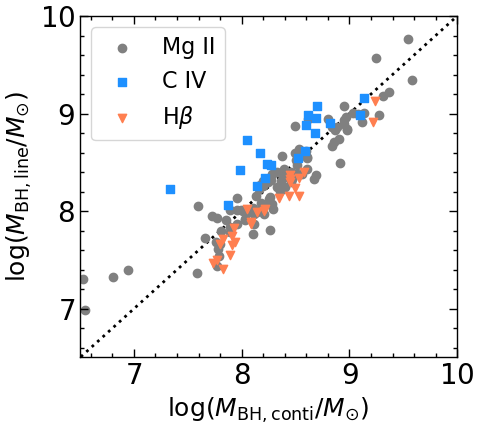

In [281]:
# TODO: Line SNR > 2

fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

#
x = np.logspace(5, 13)
ax.plot(np.log10(x), np.log10(x/1) , linestyle='dotted', color='k', zorder=-1)

mask_f = data_join['f_conti'] > -100
ax.scatter(data_join['M_MgII'][mask_f], data_join['M_MgII_line'][mask_f], label='Mg II', color='gray', marker='o')
ax.scatter(data_join['M_CIV'][mask_f], data_join['M_CIV_line'][mask_f], label='C IV', color='dodgerblue', marker='s')
ax.scatter(data_join['M_Hb'][mask_f], data_join['M_Hb_line'][mask_f], label=r'H$\beta$', color='coral', marker='v')

#ax.scatter(data_join['M_MgII'][~mask_f], data_join['M_MgII_line'][~mask_f], label='Mg II', color='gray', edgecolor='k', marker='o')
#ax.scatter(data_join['M_CIV'][~mask_f], data_join['M_CIV_line'][~mask_f], label='C IV', color='dodgerblue', edgecolor='k', marker='s')
#ax.scatter(data_join['M_Hb'][~mask_f], data_join['M_Hb_line'][~mask_f], label=r'H$\beta$', color='coral', edgecolor='k', marker='v')

ax.legend(frameon=True)
ax.set_xlim(6.5, 10)
ax.set_ylim(6.5, 10)

ax.set_xlabel(r'$\log(M_{\rm{BH}, conti} / M_{\odot})$', fontsize=18)
ax.set_ylabel(r'$\log(M_{\rm{BH}, line} / M_{\odot})$', fontsize=18)

fig.tight_layout()
fig.savefig('conti.pdf', dpi=300)

### X-ray properties

In [282]:
# Match data_join to Chandra-COSMOS and get the 2-10 keV luminosity

data_cosmos2020j = ascii.read('/Users/diegomiura/dwarf_agn_cosmos/cigale/des/data_phot.dat')

cat_chandra = SkyCoord(data_agn_updated['RA'], data_agn_updated['dec'], unit = 'deg')
#cat_chandra = SkyCoord(data_cosmos2020j['RA'], data_cosmos2020j['dec'], unit='deg')
cat_join = SkyCoord(data_join['RA'], data_join['dec'], unit='deg')

idx_join, idx_chandra, d2d, d3d = cat_chandra.search_around_sky(cat_join, 0.6*u.arcsec)

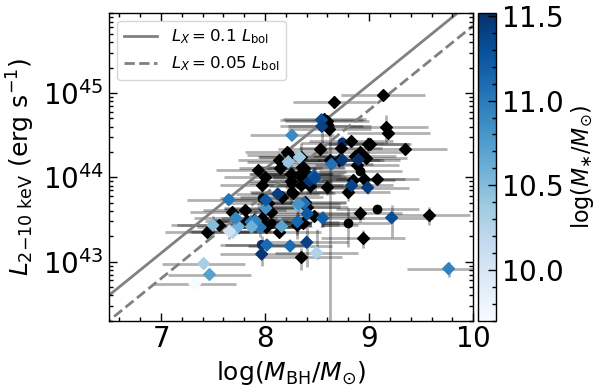

In [283]:
import scipy.constants as cst
nu_1keV = 1e3*cst.eV / cst.h

fig, ax = plt.subplots(1,1, figsize=(5, 4))
Eup = 10
Elo = 2

# Convert X-ray flux to luminosity  

#CHANDRA

Fx = (data_cosmos2020j[idx_chandra]['chandra.2to7'].data*u.mJy).to(u.erg/u.s/u.cm**2, equivalencies=u.spectral_density(4.5*u.keV)).value
Fx_err = (data_cosmos2020j[idx_chandra]['chandra.2to7_err'].data*u.mJy).to(u.erg/u.s/u.cm**2, equivalencies=u.spectral_density(4.5*u.keV)).value # mJy ->

# 
dL = cosmo.luminosity_distance(data_join['z_best'][idx_join]).to(u.cm).value
LX = (Fx*(4*np.pi*dL**2))
dLX = (Fx_err*(4*np.pi*dL**2))


mask = (data_join['M_line'][idx_join] > 0 ) & (LX > 0) & (dLX > 0)

ax.scatter(data_join['M_line'][idx_join][mask & ~mask_chi2], LX[mask & ~mask_chi2], marker='o', c='k')
im = ax.scatter(data_join['M_line'][idx_join][mask & mask_chi2], LX[mask & mask_chi2], marker='o',
                c=data_join['logMs'][idx_join][mask & mask_chi2], cmap='Blues')

ax.errorbar(data_join['M_line'][idx_join][mask], LX[mask], yerr=dLX[mask], xerr=0.4, linestyle='none', c='k', zorder=-1, alpha=0.3)


#XMM

Fx = (data_cosmos2020j[idx_chandra]['xmm.newton.0p2to12'].data*u.mJy).to(u.erg/u.s/u.cm**2, equivalencies=u.spectral_density(4.5*u.keV)).value
Fx_err = (data_cosmos2020j[idx_chandra]['xmm.newton.0p2to12_err'].data*u.mJy).to(u.erg/u.s/u.cm**2, equivalencies=u.spectral_density(4.5*u.keV)).value # mJy ->

# 
dL = cosmo.luminosity_distance(data_join['z_best'][idx_join]).to(u.cm).value
LX = (Fx*(4*np.pi*dL**2))
dLX = (Fx_err*(4*np.pi*dL**2))


mask = (data_join['M_line'][idx_join] > 0 ) & (LX > 0) & (dLX > 0)

ax.scatter(data_join['M_line'][idx_join][mask & ~mask_chi2], LX[mask & ~mask_chi2], marker='D', c='k')
im = ax.scatter(data_join['M_line'][idx_join][mask & mask_chi2], LX[mask & mask_chi2], marker='D',
                c=data_join['logMs'][idx_join][mask & mask_chi2], cmap='Blues')

ax.errorbar(data_join['M_line'][idx_join][mask], LX[mask], yerr=dLX[mask], xerr=0.4, linestyle='none', c='k', zorder=-1, alpha=0.3)





# L_bol = 10
x = np.linspace(6, 10)
L_Edd = 1.26*1e38*10**x #/ 10
ax.plot(x, 0.1*L_Edd / 10, label=r'$L_{X}{=}0.1\ L_{\rm{bol}}$', color='gray', zorder=-1)
ax.plot(x, 0.05*L_Edd / 10, label=r'$L_{X}{=}0.05\ L_{\rm{bol}}$', color='gray', zorder=-1, linestyle='dashed')
#ax.plot(x, 0.001*L_Edd, label=r'$L_{X}{=}10^{-3} L_{\rm{bol}}$', color='gray', zorder=-1, linestyle='dotted')

ax.legend(fontsize=12, frameon=True)


ax.set_yscale('log')
ax.set_xlabel(r'$\log(M_{\rm{BH}} / M_{\odot})$', fontsize=18)
ax.set_ylabel(r'$L_{2{-}10\ {\rm{keV}}}\ ({\rm{erg\ s}}^{-1}$)', fontsize=18)

ax.set_xlim(6.5, 10)
ax.set_ylim(2e42, 9e45)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(M_{\ast} / M_{\odot})$')

fig.savefig('xray.pdf', dpi=300)

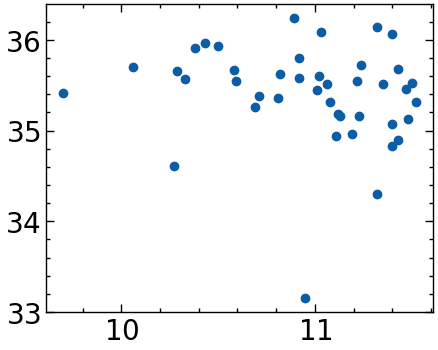

In [284]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.scatter(data_join['logMs'][idx_join][mask & mask_chi2],
        np.log10(LX[mask & mask_chi2]/10**data_join['M_line'][idx_join][mask & mask_chi2]))

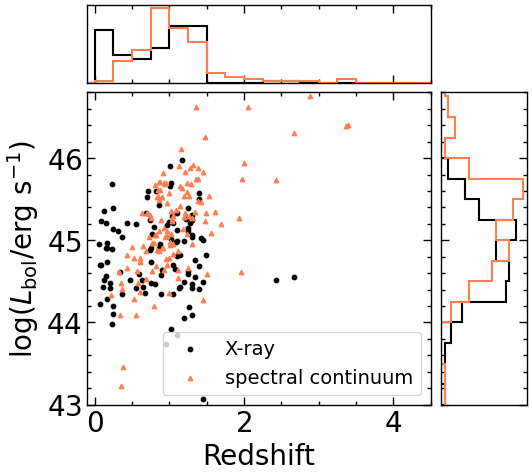

In [285]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def scatter_hist(x, y, ax, ax_histx, ax_histy, color='k', marker='o', label=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, color=color, s=10, marker=marker, label=label)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.nanmax(np.abs(x)), np.nanmax(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, histtype='step', lw=1.5, color=color)
    ax_histy.hist(y, bins=bins, orientation='horizontal', histtype='step', color=color, lw=1.5)

    ax_histx.get_yaxis().set_visible(False)
    ax_histy.get_xaxis().set_visible(False)

# Use 2-10
Eup = 10
Elo = 2

# Convert X-ray flux to luminosity  

#CHANDRA

Fx = (data_cosmos2020j[idx_chandra]['chandra.2to7'].data*u.mJy).to(u.erg/u.s/u.cm**2, equivalencies=u.spectral_density(4.5*u.keV)).value
Fx_err = (data_cosmos2020j[idx_chandra]['chandra.2to7_err'].data*u.mJy).to(u.erg/u.s/u.cm**2, equivalencies=u.spectral_density(4.5*u.keV)).value # mJy ->

# 
dL = cosmo.luminosity_distance(data_join['z_best'][idx_join]).to(u.cm).value
LX = (Fx*(4*np.pi*dL**2))
dLX = (Fx_err*(4*np.pi*dL**2))


mask = (data_join['M_line'][idx_join] > 0 ) & (LX > 0) & (dLX > 0)

ax.scatter(data_join['M_line'][idx_join][mask & ~mask_chi2], LX[mask & ~mask_chi2], marker='o', c='k')
im = ax.scatter(data_join['M_line'][idx_join][mask & mask_chi2], LX[mask & mask_chi2], marker='o',
                c=data_join['logMs'][idx_join][mask & mask_chi2], cmap='Blues')

ax.errorbar(data_join['M_line'][idx_join][mask], LX[mask], yerr=dLX[mask], xerr=0.4, linestyle='none', c='k', zorder=-1, alpha=0.3)


#XMM

Fx = (data_cosmos2020j[idx_chandra]['xmm.newton.0p2to12'].data*u.mJy).to(u.erg/u.s/u.cm**2, equivalencies=u.spectral_density(4.5*u.keV)).value
Fx_err = (data_cosmos2020j[idx_chandra]['xmm.newton.0p2to12_err'].data*u.mJy).to(u.erg/u.s/u.cm**2, equivalencies=u.spectral_density(4.5*u.keV)).value # mJy ->

# 
dL = cosmo.luminosity_distance(data_join['z_best'][idx_join]).to(u.cm).value
LX = (Fx*(4*np.pi*dL**2))
dLX = (Fx_err*(4*np.pi*dL**2))


mask = (data_join['M_line'][idx_join] > 0 ) & (LX > 0) & (dLX > 0)

ax.scatter(data_join['M_line'][idx_join][mask & ~mask_chi2], LX[mask & ~mask_chi2], marker='D', c='k')
im = ax.scatter(data_join['M_line'][idx_join][mask & mask_chi2], LX[mask & mask_chi2], marker='D',
                c=data_join['logMs'][idx_join][mask & mask_chi2], cmap='Blues')

ax.errorbar(data_join['M_line'][idx_join][mask], LX[mask], yerr=dLX[mask], xerr=0.4, linestyle='none', c='k', zorder=-1, alpha=0.3)

# Use 2-10


# Start with a square Figure.
fig = plt.figure(figsize=(5.5, 5))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(data_agn_updated['z_best'][idx_join], np.log10(10*LX), ax, ax_histx, ax_histy, label='X-ray')

# Lbol
scatter_hist(data_join['z_best'].data, data_join['Lbol'].data, ax, ax_histx, ax_histy, color='coral', marker='^', label='Spectral Continuum')


ax.legend(loc=4, frameon=True, fontsize=14)
ax.set_xlabel('Redshift', fontsize=20)
ax.set_ylabel(r'$\log(L_{\rm{bol}} / {\rm erg\ s}^{-1})$', fontsize=20)

ax.set_xlim(-.1, 4.5)
ax.set_ylim(43, 46.8)


fig.tight_layout()
fig.savefig('Lbolredshift.pdf', dpi=300)

## SAVE

In [ ]:
data_sed = ascii.read('table_mass.dat')
data_classification = ascii.read('classification.txt', delimiter='|')
data_joint = table.join(data_sed, data_agn_BH_best, keys='ID', join_type='left')
data_joint = table.join(data_agn_updated, data_joint, keys='ID', join_type='left')
data_joint = table.join(data_classification, data_joint, keys='ID', join_type='right')

data_save = table.Table()
id = data_joint['ID']
ra = data_joint['RAdeg']
dec = data_joint['DEdeg']
i = data_joint['i-mag']
z_best = np.around(data_joint['z'], 4)
z_phot = data_joint['z_phot']
Lbol = np.around(data_joint['Lbol'],2)
logMs = data_joint['logMs']
logMs_e = data_joint['logMs_e']
SF_excess = data_joint['SF_excess']
chi2nu = data_joint['chi2']
M_line = np.around(data_joint['M_line'], 2)
M_line_e = np.around(data_joint['M_line_e'], 2)
classification = data_joint['Type']

# bad values

data_save = table.Table([id, ra, dec, i, z_best, z_phot, Lbol, M_line, M_line_e, logMs, logMs_e, SF_excess, chi2nu, classification],
                        names=['ID','RAdeg','DEdeg','i-mag','z_best','z_phot','logL','logMBH','logMBH_e','logMs','logMs_e','SF_excess','chi2nu', 'classification'])

data_save['logMBH'].fill_value = -1

data_save.write('prop.txt', overwrite=True, format='latex')
data_save

ID,RAdeg,DEdeg,i-mag,z_best,z_phot,logL,logMBH,logMBH_e,logMs,logMs_e,SF_excess,chi2nu,classification
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str26
1,150.74386,2.20245,22.71,1.58,1.58,--,--,--,10.62,0.4,1.13,3.0,--
2,150.73557,2.19957,20.36,3.5026,-1.0,46.68,9.04,0.11,11.16,0.4,0.9,2.9,BL
3,150.73353,2.15646,20.88,0.979,1.03,44.8,8.27,0.31,11.25,0.4,2.03,4.4,NeV
4,150.79702,2.13888,21.01,0.5727,0.51,--,--,--,10.96,0.4,3.29,1.3,--
5,150.78259,2.19306,20.63,0.5824,-1.0,--,--,--,--,--,--,--,BL
6,150.72019,2.24803,21.13,0.6652,0.62,44.89,8.04,0.0,10.87,0.4,1.96,0.5,BL
7,150.78838,2.34399,19.82,1.9555,2.0,--,--,--,10.16,0.4,1.31,8.8,BL
8,150.71511,2.48483,19.2,2.0051,-1.0,--,--,--,--,--,--,--,BL
9,150.71391,1.97214,22.87,0.3396,1.53,--,--,--,11.6,0.4,3.28,0.8,Noisy


In [ ]:
data_save['logMBH']

--
9.04
8.27
--
--
8.04
--
--
--
--
--


In [ ]:
data_sed = ascii.read('table_mass.txt')
data_classification = ascii.read('classification.txt', delimiter='|')
data_joint = table.join(data_sed, data_classification, keys='ID', join_type='left')

data_joint

ID,logMs,logMs_e,SF_excess,chi2,Type
int64,float64,float64,float64,float64,str26
1,10.64,0.12,1.1,3.0,--
2,11.53,0.13,0.8,1.9,BL
3,11.4,0.11,2.1,0.7,NeV
4,10.78,0.2,3.5,1.3,--
6,10.84,0.13,1.9,0.5,BL
7,10.52,0.1,1.0,7.8,BL
9,11.56,0.03,3.2,0.8,Noisy
10,11.08,0.05,1.6,3.1,Noisy?
11,10.71,0.06,1.7,6.7,NeV?
